<h1>Predicting the loss rate of a wireless link</h1>
This notebook works on the data collected at the ENS Lyon and the INSA Lyon as part of the wireless networking section in the ANR Concerto project. The goal is to first study the data and see which performance metrics can be useful, and to then build a prediction model for them.

Every line in the data files loaded here represents the average of 100ms of experimental data. 
The measurements were taken at the ENS Lyon (1H, 2nd, 3rd) and the INSA Lyon (Anechoic chamber) by varying the distance between two IEEE 802.11ac APs acting as source and destination. There is a continuous, saturated UDP stream from the source AP to the destination. 

Because of the nature of the cards and system in use, a third AP placed close to the destination AP is acting as monitor and capturing the exchanged frames. This introduces measurement errors due to the fact that what the monitor captures and what the destination captures will not be the exact same stream of frames. To circumvent this issue, we have considered several different ways of computing the channel quality based on both the data frames and the ACK frames captured by the monitor. These computations are detailed later in the notebook. 

The goal is to build a robust model capable of predicting the link quality that 1) provides an accurate prediction of the link quality and that 2) requires few input features. 

Some of the data will be removed as it seems to produce no measurable lossrate (Anechoic chamber with movement) or because there are too few samples to learn any conclusive rules (Anechoic chamber with obstacle).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors

%matplotlib inline

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['font.size'] = 13

In [2]:
# define custom colormaps
norm = matplotlib.colors.Normalize(-1,1)
# summer colors (yellow to dar blue with orange and purple)
color1 = '#ffa600'
color2 = '#ff6361'
color3 = '#bc5090'
color4 = '#003f5c'
colors_summer = [[norm(-1.0), color1],
          [norm(-0.6), color2],
          [norm( 0.6), color3],
          [norm( 1.0), color4]]
cmap_summer = matplotlib.colors.LinearSegmentedColormap.from_list("", colors_summer)

# summer colors divergent
color1d = '#003f5c'
color2d = '#4f697e'
color3d = '#8a96a2'
color4d = '#c6c6c6'
color5d = '#e1a9a3'
color6d = '#f38982'
color7d = '#ff6361'
color8dyellow = '#ffc16a' #an extra shade of yellow
color9dgray = '#2a2b2d'
colors_summer = [[norm(-1.0), color1d],
          [norm(-0.6), color2d],
          [norm(-0.3), color3d],
          [norm( 0.0), color4d],
          [norm( 0.3), color5d],
          [norm( 0.6), color6d],
          [norm( 1.0), color7d]]
cmap_summer_divergent = matplotlib.colors.LinearSegmentedColormap.from_list("", colors_summer)
colorlist_summer_divergent = [color1d, color7d, color3d, color5d, color2d, color6d, color4d, color8dyellow, color9dgray]
# salmon-blue colormap
color1sb = '#54bebe'
color2sb = '#8ad6bb'
color3sb = '#c2eabd'
color4sb = '#f9fdca'
color5sb = '#f9d491'
color6sb = '#ffa46e'
color7sb = '#ff6c6c'
colors_salmon_blue = [[norm(-1.0), color1sb],
          [norm(-0.6), color2sb],
          [norm(-0.3), color3sb],
          [norm( 0.0), color4sb],
          [norm( 0.3), color5sb],
          [norm( 0.6), color6sb],
          [norm( 1.0), color7sb]]
cmap_salmon_blue = matplotlib.colors.LinearSegmentedColormap.from_list("", colors_salmon_blue)
colorlist_salmon_blue = [color1sb, color7sb, color3sb, color5sb, color2sb, color6sb, color4sb]

sns.set_palette(colorlist_summer_divergent)

<h4>Read the data and assign the scenario name</h4>

In [3]:
df1 = pd.read_csv('1H/complete_data.csv',sep='\t')
df1['Scenario'] = 'First floor'
df2 = pd.read_csv('2nd/complete_data.csv',sep='\t')
df2['Scenario'] = 'Second floor'
df3 = pd.read_csv('3rd/complete_data.csv',sep='\t')
df3['Scenario'] = 'Third floor'
df4 = pd.read_csv('CA/complete_data.csv',sep='\t')
df4['Scenario'] = 'Anechoic ch.'
df5 = pd.read_csv('CA_move/complete_data.csv',sep='\t')
df5['Scenario'] = 'Anechoic mvmnt'
df6 = pd.read_csv('CA_doubles/complete_data.csv',sep='\t')
df6['Scenario'] = 'Anechoic ch.'
df7 = pd.read_csv('1H_obstacle/complete_data.csv',sep='\t')
df7['Scenario'] = 'Obstacle 1H'
df8 = pd.read_csv('2nd_obstacle/complete_data.csv',sep='\t')
df8['Scenario'] = 'Obstacle 2nd'
df9 = pd.read_csv('3rd_obstacle/complete_data.csv',sep='\t')
df9['Scenario'] = 'Obstacle 3rd'
df10 = pd.read_csv('CA_obstacle/complete_data.csv',sep='\t')
df10['Scenario'] = 'Anechoic obstacle'
#df11 = pd.read_csv('2nd_unsaturated/complete_data.csv', sep='\t')
#df11['Scenario'] = 'Unsaturated 2nd'

df12 = pd.read_csv('tcp/complete_data.csv',sep='\t')
df12['Scenario'] = 'tcp'

df13 = pd.read_csv('2nd_unsaturated_100M_500o/complete_data.csv',sep='\t')
df13['Scenario'] = 'unsat100M500o'

df14 = pd.read_csv('2nd_unsaturated_100M_def/complete_data.csv',sep='\t')
df14['Scenario'] = 'unsat100Mdef'

df15 = pd.read_csv('2nd_unsaturated_1G_500o/complete_data.csv',sep='\t')
df15['Scenario'] = 'unsat1G500o'

df16 = pd.read_csv('2nd_unsaturated_5M_500o/complete_data.csv',sep='\t')
df16['Scenario'] = 'unsat5M500o'

df17 = pd.read_csv('2nd_unsaturated_5M_def/complete_data.csv',sep='\t')
df17['Scenario'] = 'unsat5Mdef'

df18 = pd.read_csv('2nd_unsaturated_100M_full/complete_data.csv',sep='\t')
df18['Scenario'] = 'unsat100Mfull'

df19 = pd.read_csv('2nd_unsaturated_5M_full/complete_data.csv',sep='\t')
df19['Scenario'] = 'unsat5Mfull'


df20 = pd.read_csv('2nd_unsaturated_def_full/complete_data.csv',sep='\t')
df20['Scenario'] = 'unsatdeffull'

df21 = pd.read_csv('2nd_unsaturated_500o_full/complete_data.csv',sep='\t')
df21['Scenario'] = 'unsat500ofull'



In [4]:
df21.head()

,time,mcs,nss,bw,rssi,throughput_monitor,datarate,pktlost_ack,nbpkt_monitor,retry,nbpkt_ack,pktlost_seq_initial,pktlost_seq_new,bad_fcs,distance,antenna,LoS,Scenario
0,8.100622,7.0,3.0,80.0,-57.8462,81652.2,975.000,0.0,13.0,1.0,3309.0,11.0,3339.0,0.0,14,vertical,1,unsat500ofull
1,8.200651,7.0,3.0,80.0,-57.8571,132561.0,975.000,0.0,21.0,0.0,124.0,19.0,125.0,0.0,14,vertical,1,unsat500ofull
2,8.301749,7.0,3.0,75.0,-57.4375,100022.0,909.375,0.0,16.0,3.0,125.0,12.0,102.0,0.0,14,vertical,1,unsat500ofull
3,8.401980,7.0,3.0,80.0,-58.0833,75664.9,975.000,0.0,12.0,1.0,126.0,9.0,94.0,0.0,14,vertical,1,unsat500ofull
4,8.502559,7.0,3.0,80.0,-58.1579,119388.0,975.000,0.0,19.0,0.0,126.0,17.0,136.0,0.0,14,vertical,1,unsat500ofull


<h4>The features:</h4>
<li>Time: timestamp of the event in seconds</li>
<li>MCS: Modulation and Coding Scheme (MCS) index (relates to the data rate, higher MCS index means higher data rate)</li>
<li>NSS: Number of Spatial Streams (number of antennas used for the transmission)</li>
<li>BW: The bandwidth in [20, 40, 80, 160] MHz </li>
<li>RSSI: Measures signal strength in dBm</li>
<li>Throughput monitor: The throughput in bits per second (layer 2, i.e., all layer 3 data is considered as useful). It is calculated as the number of frames correctly received by the monitor X the average frame length. Though IPerf generates data packets of equal length, due to aggregation and fragmentation the frame length is not always constant</li>
<li>Datarate: The physical datarate used for the transmission of the layer 2 data (impacted by BW, MCS, NSS, GI (guard interval))</li>
<li>Pktlost_ack: The number of frames counted as lost from the "missing frames" field in the ACKs</li>
<li>Nbpkt_monitor: Total number of frames captured by the monitor and sent by the source</li>
<li>Retry: Number of frames captured by the moniter having a "retry = 1" flaf</li>
<li>Nbpkt_ack: Total number of frames acknowledged in the ACKs captured by the monitor</li>
<li>Pktlost_seq_initial: The number of lost frames based on sequential numbers. This computation mainly counts the number of events that can be seen as a loss (a hole in the list of sequential numbers will always be counted as a single error, no matter how many consecutive frames were lost. For example, [1,2,5] and [1,2,3,5] will both generate one error)</li>
<li>Pktlost_seq_new: The number of lost frames based on sequential numbers. This computation should count exactly how many frames were lost, however it is less precise than planned and we do not use it for the time being</li>
<li>Bad_fcs: Number of frames seen by the monitor with the Bad FCS flag set to 1 </li>
<li>Distance: The distance in meters between the source and the destination</li>
<li>Antenna: The orientation of the antenna for all three APs (source, destination, monitor). The orientation can be left, fan, vertical, horizontal</li>
<li>LoS: Line of Sight. Always 1 except for the scenarios including obstacles</li>
<li>Scenario: The physical location of the experiment and whether an obstacle was present or not</li>
<li>Bad FCS: The number of frames having a bad_fcs flag set to True</li>

In [5]:
# the df5 and df10 are excluded for the moment because they are not representative, i.e., too few samples and not enough variety in them, 
# but they can be added to this list
frames = [df1, df2, df3, df7, df8, df9,df13, df14, df16, df17]
for df in frames:
    print (df)
    df['retry_ack'] = df['retry']/df['nbpkt_ack']
    df['pktlost_ack'] = df['pktlost_ack'].astype(dtype=float)
    df['retry_monitor'] = df['retry']/df['nbpkt_monitor']
    df['missing_frames_ack'] = df['pktlost_ack']/df['nbpkt_ack']
    df['missing_frames_monitor'] = df['pktlost_ack']/df['nbpkt_monitor']
    df['lossrate_ack'] = df['pktlost_seq_initial']/df['nbpkt_ack']
    df['lossrate_monitor'] = df['pktlost_seq_initial']/df['nbpkt_monitor']
    df.replace([np.inf, -np.inf], np.nan, inplace=True) 
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(subset=['pktlost_ack'], inplace=True)
    df.index = range(len(df.index))

data_all = pd.concat(frames)
data_all.index = range(len(data_all.index))
data_copy = data_all.copy()
len(data_all)



##unsat frame
frames_unsat = [df13, df14, df16, df17]
for df in frames_unsat:
    print (df)
    df['retry_ack'] = df['retry']/df['nbpkt_ack']
    df['pktlost_ack'] = df['pktlost_ack'].astype(dtype=float)
    df['retry_monitor'] = df['retry']/df['nbpkt_monitor']
    df['missing_frames_ack'] = df['pktlost_ack']/df['nbpkt_ack']
    df['missing_frames_monitor'] = df['pktlost_ack']/df['nbpkt_monitor']
    df['lossrate_ack'] = df['pktlost_seq_initial']/df['nbpkt_ack']
    df['lossrate_monitor'] = df['pktlost_seq_initial']/df['nbpkt_monitor']
    df.replace([np.inf, -np.inf], np.nan, inplace=True) 
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(subset=['pktlost_ack'], inplace=True)
    df.index = range(len(df.index))

data_unsat = pd.concat(frames_unsat)
data_unsat.index = range(len(data_unsat.index))
data_unsat_copy = data_unsat.copy()
len(data_unsat)

##sat frame sans CA
frames_sat = [df1, df2, df3, df7, df8, df9]
for df in frames_sat:
    print (df)
    df['retry_ack'] = df['retry']/df['nbpkt_ack']
    df['pktlost_ack'] = df['pktlost_ack'].astype(dtype=float)
    df['retry_monitor'] = df['retry']/df['nbpkt_monitor']
    df['missing_frames_ack'] = df['pktlost_ack']/df['nbpkt_ack']
    df['missing_frames_monitor'] = df['pktlost_ack']/df['nbpkt_monitor']
    df['lossrate_ack'] = df['pktlost_seq_initial']/df['nbpkt_ack']
    df['lossrate_monitor'] = df['pktlost_seq_initial']/df['nbpkt_monitor']
    df.replace([np.inf, -np.inf], np.nan, inplace=True) 
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(subset=['pktlost_ack'], inplace=True)
    df.index = range(len(df.index))

data_sat = pd.concat(frames_sat)
data_sat.index = range(len(data_sat.index))
data_sat_copy = data_sat.copy()
len(data_sat)


              time           mcs           nss         bw     rssi  \
0         8.100007       7.00304       2.00000  80.000000 -59.4833   
1         8.200325       6.99433       2.00324  80.000000 -59.5041   
2         8.300506       7.00000       2.00000  80.000000 -59.4887   
3         8.400762       7.03372       2.00293  80.000000 -59.5176   
4         8.501195       7.00000       2.00000  80.000000 -59.5468   
...            ...           ...           ...        ...      ...   
121771  127.115757       5.00434       3.00000  80.000000 -62.3449   
121772  127.216032       7.00000       3.00000  80.000000 -63.0000   
121773  127.354999       5.02899       3.00000  80.000000 -61.9130   
121774  127.502358       7.00000       3.00000  80.000000 -28.5000   
121775          ##  239189.00000  551132.00000   0.433996      NaN   

        throughput_monitor  datarate  pktlost_ack  nbpkt_monitor  retry  \
0              39211800.00   650.396          0.0         1314.0    0.0   
1        

             time           mcs           nss         bw     rssi  \
0        8.100470       8.99000       2.00500  80.000000 -32.0550   
1        8.203802       8.98558       2.00721  80.000000 -32.0793   
2        8.304058       8.99519       2.00240  80.000000 -32.0144   
3        8.404690       8.99048       2.00476  80.000000 -32.0238   
4        8.504947       8.98558       2.00721  80.000000 -32.0216   
...           ...           ...           ...        ...      ...   
67556  127.062046       7.00000       3.00000  80.000000 -54.5000   
67557  127.171335       7.00000       3.00000  80.000000 -54.5000   
67558  128.665337           NaN           NaN        NaN      NaN   
67559  128.765749       7.00000       3.00000  80.000000 -53.0000   
67560          ##  322233.00000  499527.00000   0.645076      NaN   

       throughput_monitor  datarate  pktlost_ack  nbpkt_monitor  retry  \
0             13135800.00   866.545          0.0          400.0    2.0   
1             12943700.

             time      mcs      nss    bw     rssi  throughput_monitor  \
0        8.100061  8.98750  2.00625  80.0 -30.9325         11922200.00   
1        8.200898  8.99004  2.00498  80.0 -30.9278         11942200.00   
2        8.300904  8.99016  2.00492  80.0 -30.9397         12127400.00   
3        8.401354  8.99244  2.00378  80.0 -30.9219         11936800.00   
4        8.501562  8.99485  2.00257  80.0 -30.8391         11667800.00   
...           ...      ...      ...   ...      ...                 ...   
67615  126.956604  7.00000  3.00000  80.0 -54.5932         11854300.00   
67616  127.057220  7.00000  3.00000  80.0 -54.6489         11651700.00   
67617  127.252839  7.00000  3.00000  80.0 -54.6957           142138.00   
67618  129.524825      NaN      NaN   NaN      NaN                 NaN   
67619  129.625248  7.00000  3.00000  80.0 -56.0000             3076.98   

       datarate  pktlost_ack  nbpkt_monitor  retry  ...  distance   antenna  \
0       866.681          1.0    

              time      mcs      nss    bw     rssi  throughput_monitor  \
0         8.100007  7.00304  2.00000  80.0 -59.4833         39211800.00   
1         8.200325  6.99433  2.00324  80.0 -59.5041         36591800.00   
2         8.300506  7.00000  2.00000  80.0 -59.4887         38414100.00   
3         8.400762  7.03372  2.00293  80.0 -59.5176         40886200.00   
4         8.501195  7.00000  2.00000  80.0 -59.5468         38911900.00   
...            ...      ...      ...   ...      ...                 ...   
121666  127.014513  7.00000  3.00000  80.0 -63.5000            60916.40   
121667  127.115757  5.00434  3.00000  80.0 -62.3449         13621400.00   
121668  127.216032  7.00000  3.00000  80.0 -63.0000            30895.00   
121669  127.354999  5.02899  3.00000  80.0 -61.9130          5876480.00   
121670  127.502358  7.00000  3.00000  80.0 -28.5000             4397.43   

        datarate  pktlost_ack  nbpkt_monitor  retry  ...  distance   antenna  \
0        650.396   

474989

/tmp/ipykernel_2201033/760826168.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  data_all.drop('time', axis=1).hist(ax = ax)


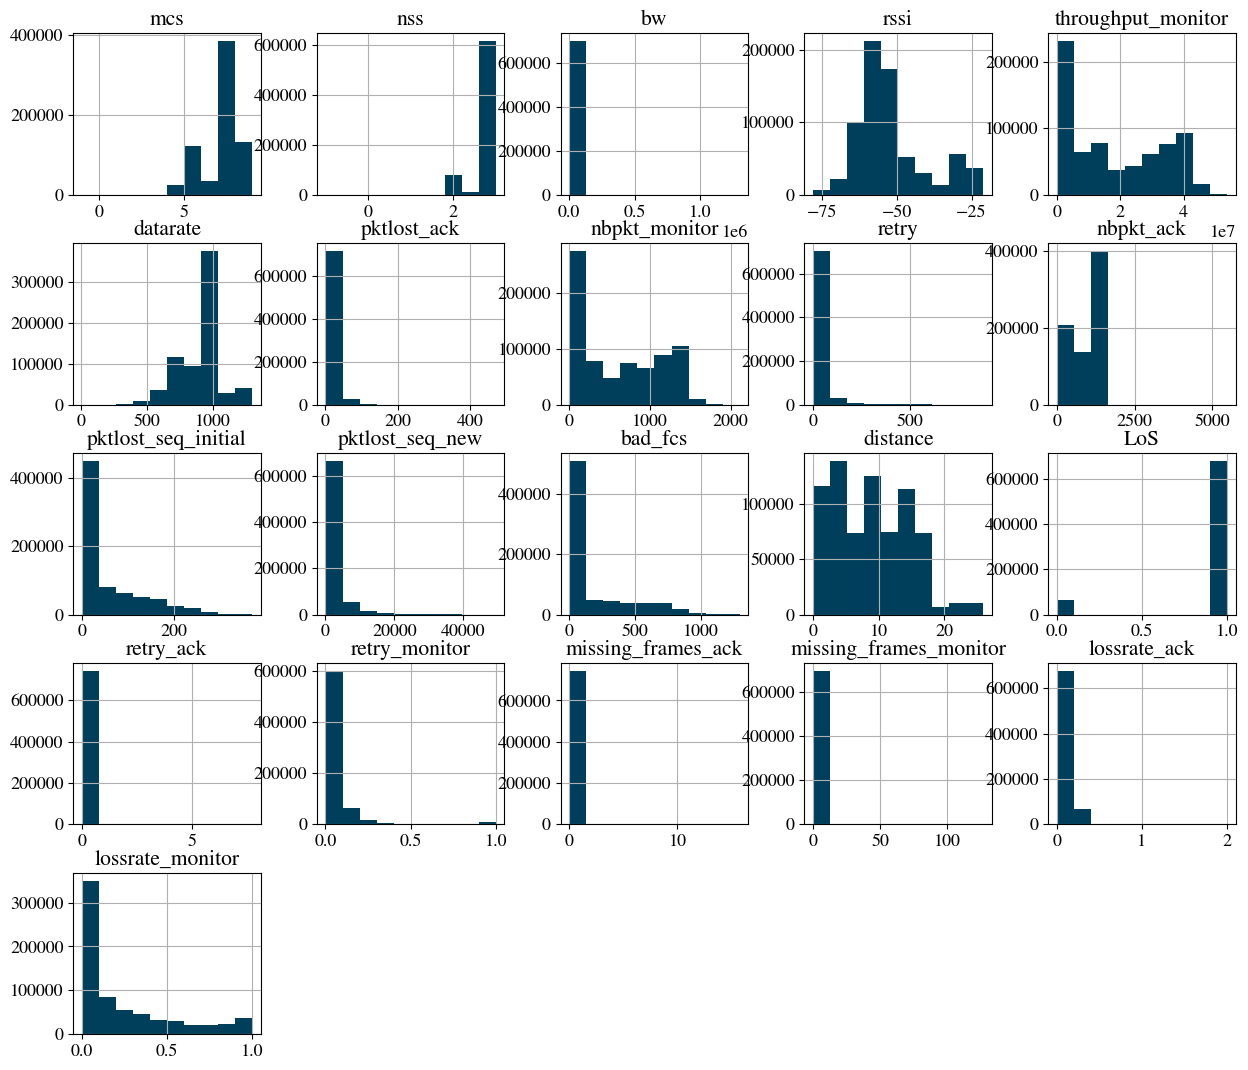

/tmp/ipykernel_2201033/760826168.py:8: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  data_unsat.drop('time', axis=1).hist(ax = ax)


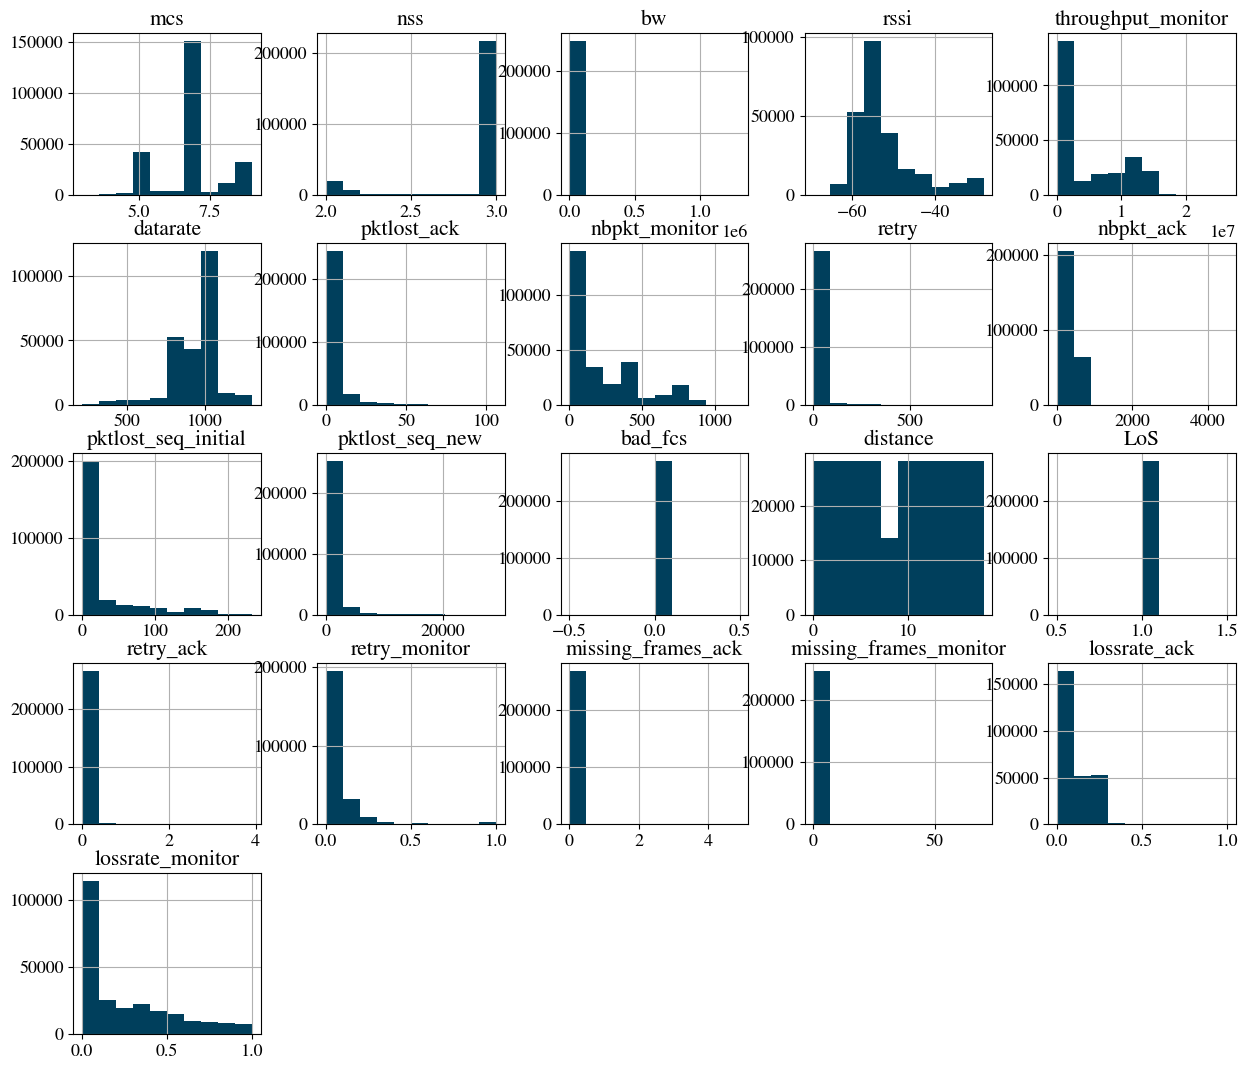

/tmp/ipykernel_2201033/760826168.py:13: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  data_sat.drop('time', axis=1).hist(ax = ax)


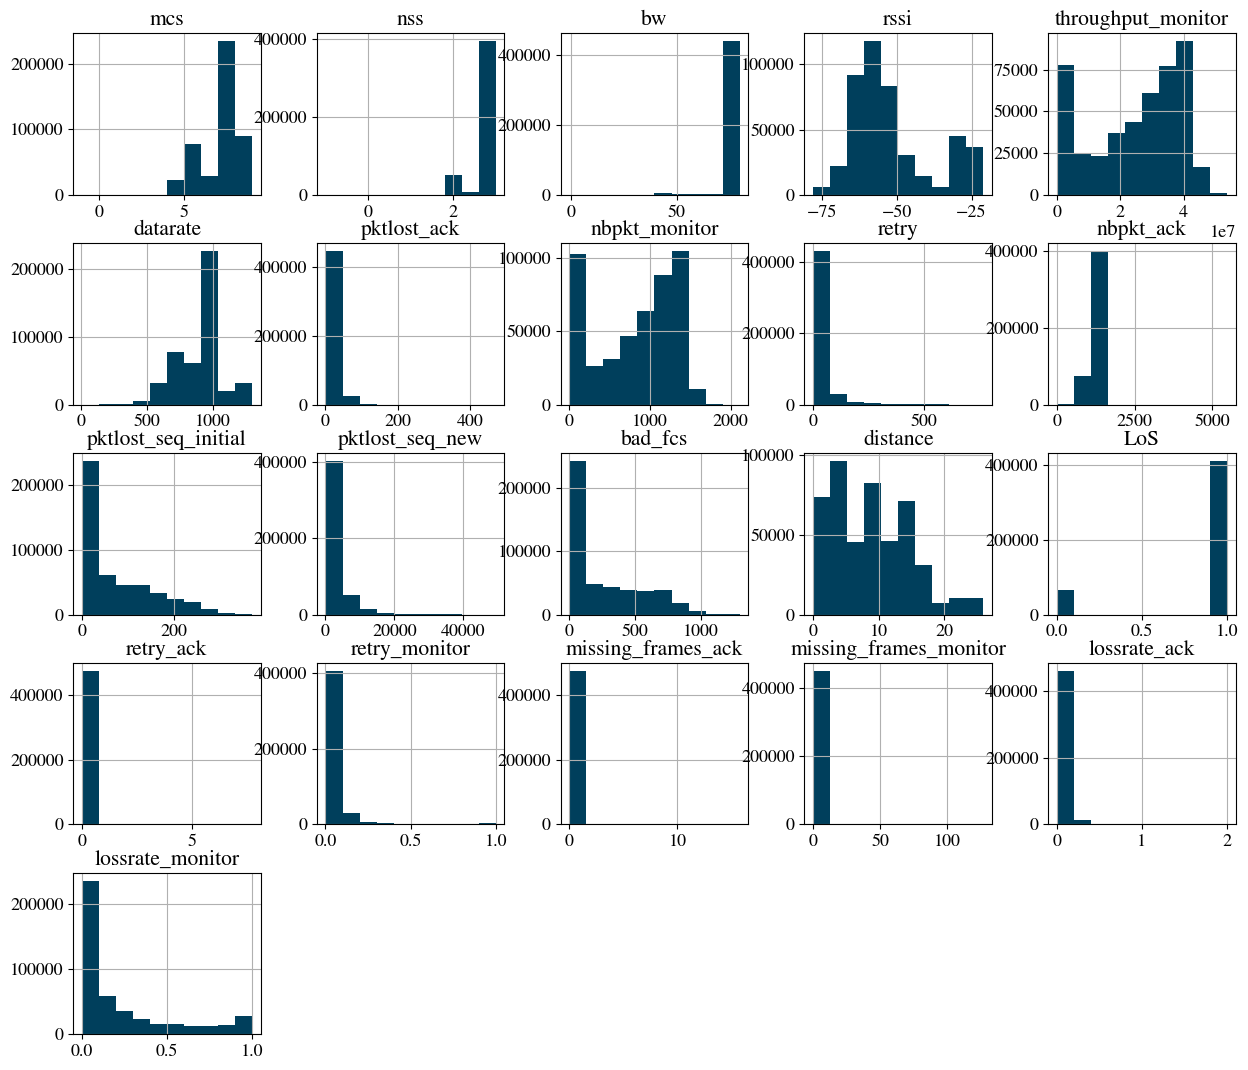

In [6]:
fig = plt.figure(figsize=(15,13))
ax = fig.gca()
data_all.drop('time', axis=1).hist(ax = ax)
plt.show()

fig = plt.figure(figsize=(15,13))
ax = fig.gca()
data_unsat.drop('time', axis=1).hist(ax = ax)
plt.show()

fig = plt.figure(figsize=(15,13))
ax = fig.gca()
data_sat.drop('time', axis=1).hist(ax = ax)
plt.show()

In [7]:
# data_all['bad_fcs'].value_counts()

In [8]:
data_all[data_all['nbpkt_ack'] < data_all['pktlost_ack']][['time', 'pktlost_ack', 'nbpkt_ack', 'Scenario']]

data_unsat[data_unsat['nbpkt_ack'] < data_unsat['pktlost_ack']][['time', 'pktlost_ack', 'nbpkt_ack', 'Scenario']]

data_sat[data_sat['nbpkt_ack'] < data_sat['pktlost_ack']][['time', 'pktlost_ack', 'nbpkt_ack', 'Scenario']]

,time,pktlost_ack,nbpkt_ack,Scenario
5133,45.431578,123.0,79.0,First floor
59191,97.861739,62.0,16.0,First floor
76388,99.705173,63.0,4.0,First floor
164755,118.720966,64.0,51.0,Second floor
164978,21.692999,54.0,49.0,Second floor
164979,21.794091,64.0,40.0,Second floor
187199,127.186845,64.0,22.0,Second floor
353482,31.508351,63.0,4.0,Second floor


We clean up the data a little bit so as to have more bounded metrics we can later use to performance evaluation and building a model. Most of the instances removed are the ones that have NaN values. These are usually the cases when only the ACKs are captured by the monitor and not the data frames. In such cases, it is impossible to calculate the MCS index, BW, NSS... because no data frames were present that allow to extract that information. We still keep these instances in the original data base in case we wish to use them later. 

42490


/tmp/ipykernel_2201033/1916995283.py:10: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  data_cleaned.hist(ax=ax)


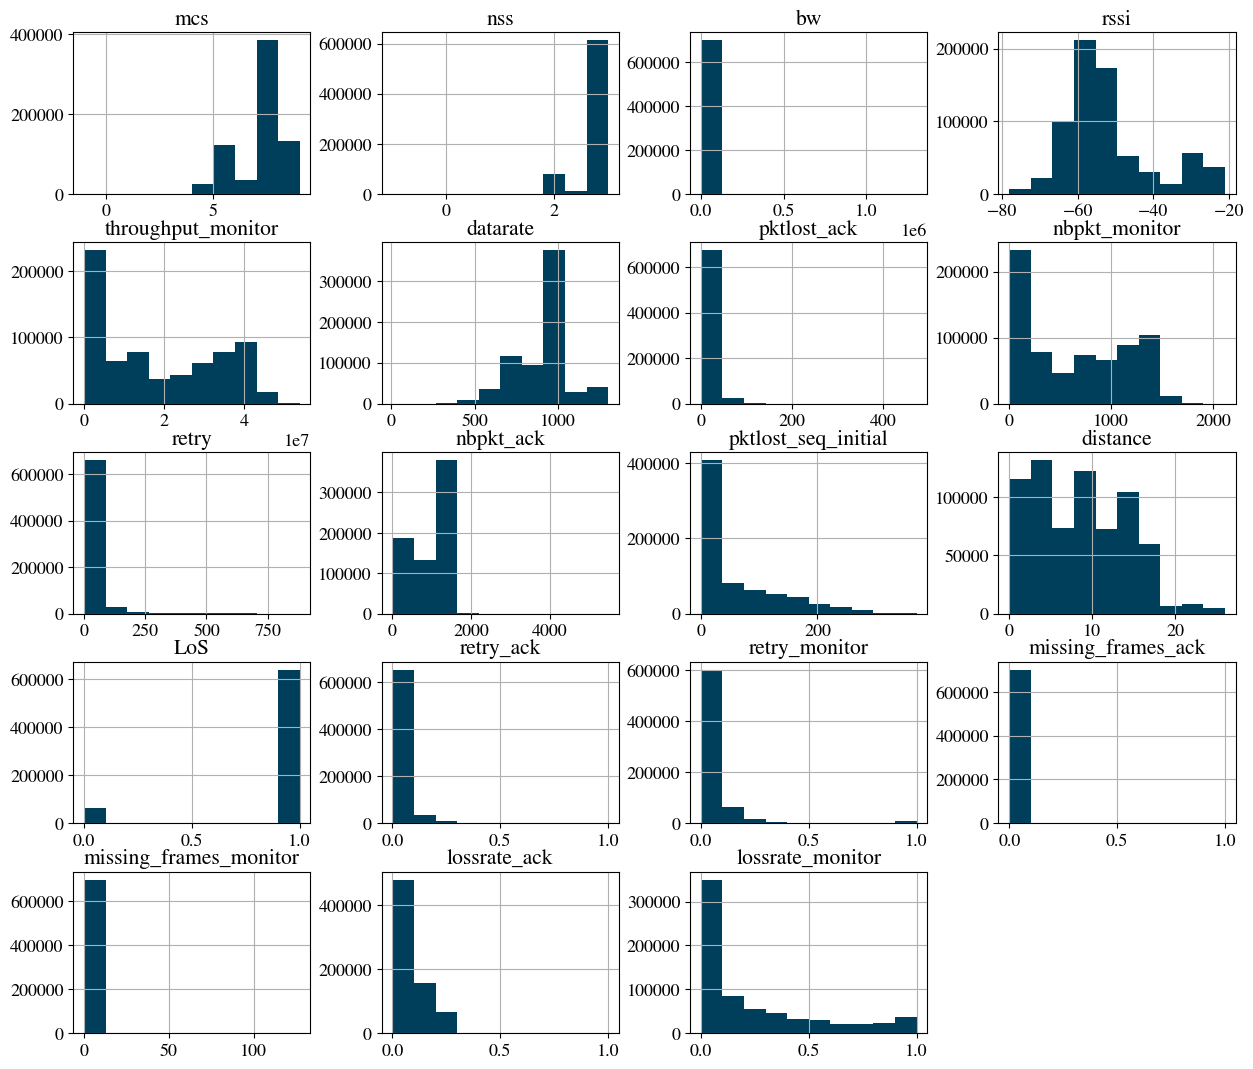

21452


/tmp/ipykernel_2201033/1916995283.py:24: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  data_cleaned_unsat.hist(ax=ax)


<Figure size 1500x1300 with 0 Axes>

21038


/tmp/ipykernel_2201033/1916995283.py:37: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  data_cleaned_sat.hist(ax=ax)


<Figure size 1500x1300 with 0 Axes>

In [9]:
fig = plt.figure(figsize=(15,13))
ax = fig.gca()
data_cleaned = data_all.copy()
data_cleaned.dropna(inplace=True)
data_cleaned.drop(data_cleaned[data_cleaned['retry_ack'] > 1].index, axis=0, inplace=True)
data_cleaned.drop(data_cleaned[data_cleaned['missing_frames_ack'] > 1].index, axis=0, inplace=True)
data_cleaned.drop(data_cleaned[data_cleaned['lossrate_ack'] > 1].index, axis=0, inplace=True)
data_cleaned.drop(['bad_fcs', 'pktlost_seq_new'], axis=1, errors='ignore', inplace=True)
print(len(data_all) - len(data_cleaned))
data_cleaned.hist(ax=ax)
data_cleaned.index = range(len(data_cleaned))
plt.show()


fig_unsat = plt.figure(figsize=(15,13))
ax = fig.gca()
data_cleaned_unsat = data_unsat.copy()
data_cleaned_unsat.dropna(inplace=True)
data_cleaned_unsat.drop(data_cleaned_unsat[data_cleaned_unsat['retry_ack'] > 1].index, axis=0, inplace=True)
data_cleaned_unsat.drop(data_cleaned_unsat[data_cleaned_unsat['missing_frames_ack'] > 1].index, axis=0, inplace=True)
data_cleaned_unsat.drop(data_cleaned_unsat[data_cleaned_unsat['lossrate_ack'] > 1].index, axis=0, inplace=True)
data_cleaned_unsat.drop(['bad_fcs', 'pktlost_seq_new'], axis=1, errors='ignore', inplace=True)
print(len(data_unsat) - len(data_cleaned_unsat))
data_cleaned_unsat.hist(ax=ax)
data_cleaned_unsat.index = range(len(data_cleaned_unsat))
plt.show()

fig_sat = plt.figure(figsize=(15,13))
ax = fig.gca()
data_cleaned_sat = data_sat.copy()
data_cleaned_sat.dropna(inplace=True)
data_cleaned_sat.drop(data_cleaned_sat[data_cleaned_sat['retry_ack'] > 1].index, axis=0, inplace=True)
data_cleaned_sat.drop(data_cleaned_sat[data_cleaned_sat['missing_frames_ack'] > 1].index, axis=0, inplace=True)
data_cleaned_sat.drop(data_cleaned_sat[data_cleaned_sat['lossrate_ack'] > 1].index, axis=0, inplace=True)
data_cleaned_sat.drop(['bad_fcs', 'pktlost_seq_new'], axis=1, errors='ignore', inplace=True)
print(len(data_sat) - len(data_cleaned_sat))
data_cleaned_sat.hist(ax=ax)
data_cleaned_sat.index = range(len(data_cleaned_sat))
plt.show()



I removed the infinities (replaced them with NaNs) that occur because the number of frames as counted by the ACKs is always zero. This happens often in the anechoic chamber where the closeness of the monitor and the destination (that transmits the ACKs) makes it impossible for the monitor to properly receive the ACKs. 


**<h4>Choosing relevant performance metrics</h4>**

We now only have >100% loss when using the metric "missing_frames_monitor", i.e., the ratio between the number of lost frames as reported by the ACKs and the number of frames counted as well received by the monitor. This is normal as we know that in many traces the monitor actually did not capture many frames that are later acknowledged in the BACKs, meaning that the communication was going well between the source and the destination, but the monitor missed it. 

The values that are reasonably bounded are the **retry_monitor** and **retry_ack** (the number of retries seen by the monitor divided by 1) the number of frames seen by the monitor or 2) the number of frames acknowledged in the BACKs), the **lossrate_monitor** and **lossrate_ack** (the number of missing sequence numbers (initial computation based on gaps) divided by 1) the number of frames seen by the monitor or 2) the number of frames acknowledged in the BACKs) and the **missing_frames_ack** (the number of missing frames in the BACKs and divided by the number of frames acknowledged in the BACKs).

**<h2>Correlations</h2>**

We look at [Pearson\'s](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient), [Spearman's](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient), and [Kendall's](https://en.wikipedia.org/wiki/Kendall_rank_correlation_coefficient) correlation coefficients for linear and quadratic features. The goal is to find the features, or combinations of features, that correlate the most with the link quality metric we wish to predict.

The current code does only Pearson's, but simply change the "method" variable to "spearman" or "kendall".


In [10]:
from sklearn.preprocessing import PolynomialFeatures
def features_correlation_simple(X, Y_1, Y_2, scenario, label, degree=2, method = 'spearman', threshold = 0.0):
    # create polynomial features
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    poly_features = poly.fit_transform(X)
    # calculate correlation coefficients 
    poly_features = pd.DataFrame(poly_features, columns=poly.get_feature_names_out(input_features=X.columns))
    poly_features[label[0]] = Y_1
    poly_features[label[1]] = Y_2
    poly_features['Scenario'] = scenario
    y1_corr = poly_features.corr(method=method)[label[0]]
    y2_corr = poly_features.corr()[label[1]]

    indexes = ([y1_corr > threshold] or [y2_corr > threshold])[0]
    y1_corr = y1_corr[indexes]
    y2_corr = y2_corr[indexes]

    sorted_index = y1_corr.abs().argsort()
    fig, ax = plt.subplots(figsize = (20,7))    
    x_axis = np.arange(len(y1_corr))
    ax.bar(x_axis-0.2, height=y1_corr[sorted_index].abs(), width=0.4, label=label[0])
    ax.bar(x_axis+0.2, height=y2_corr[sorted_index].abs(), width=0.4, label=label[1])

    plt.legend(loc='upper left')
    plt.xticks(x_axis, y1_corr.keys()[sorted_index], rotation=90)
    threshold = 0.5
    plt.axhline(threshold, ls='dotted', color=color9dgray, lw=4)
    
    return y1_corr, y2_corr

We remove some features from the correlation plots from the start, as they are have very small correlations. The threshold is set to 0.0 by default, but choose a higher value to only retrieve the relevant features. 
This part is slow to execute, it can take several minutes.  


In [11]:
threshold = 0.0

/tmp/ipykernel_2200417/832691868.py:11: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  y1_corr = poly_features.corr(method=method)[label[0]]
/tmp/ipykernel_2200417/832691868.py:12: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  y2_corr = poly_features.corr()[label[1]]
/tmp/ipykernel_2200417/832691868.py:11: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  y1_corr = poly_features.corr(method=method)[label[0]]
/tmp/ipykernel_2200417/832691868.py:12: FutureWarning: The default value o

Text(0.5, 1.0, "Pearson's correlation coefficient")

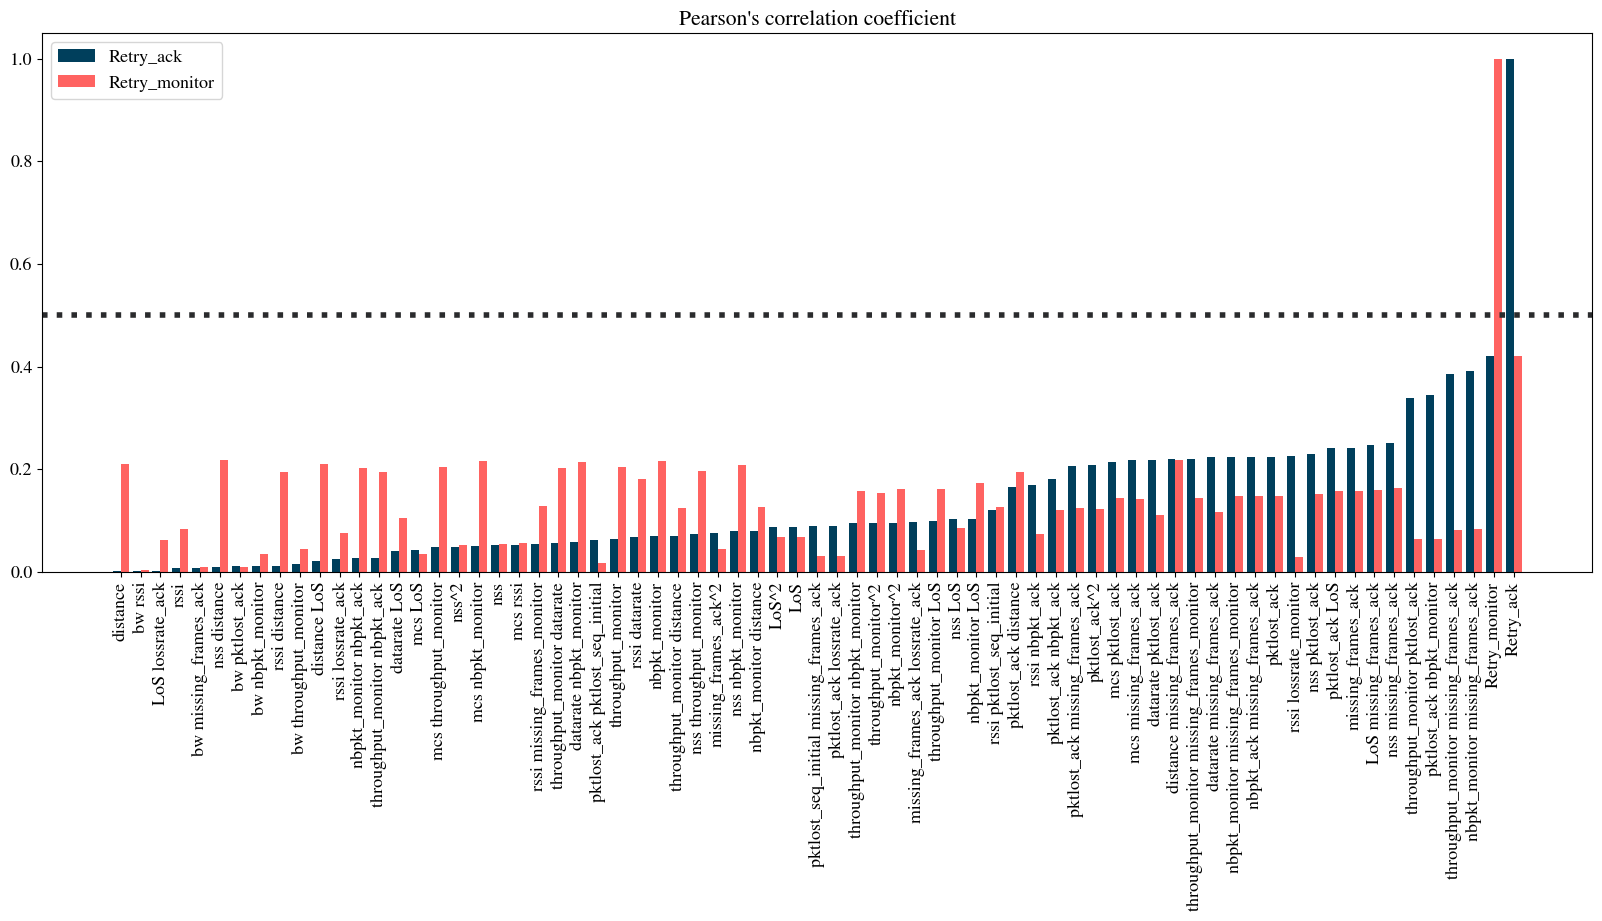

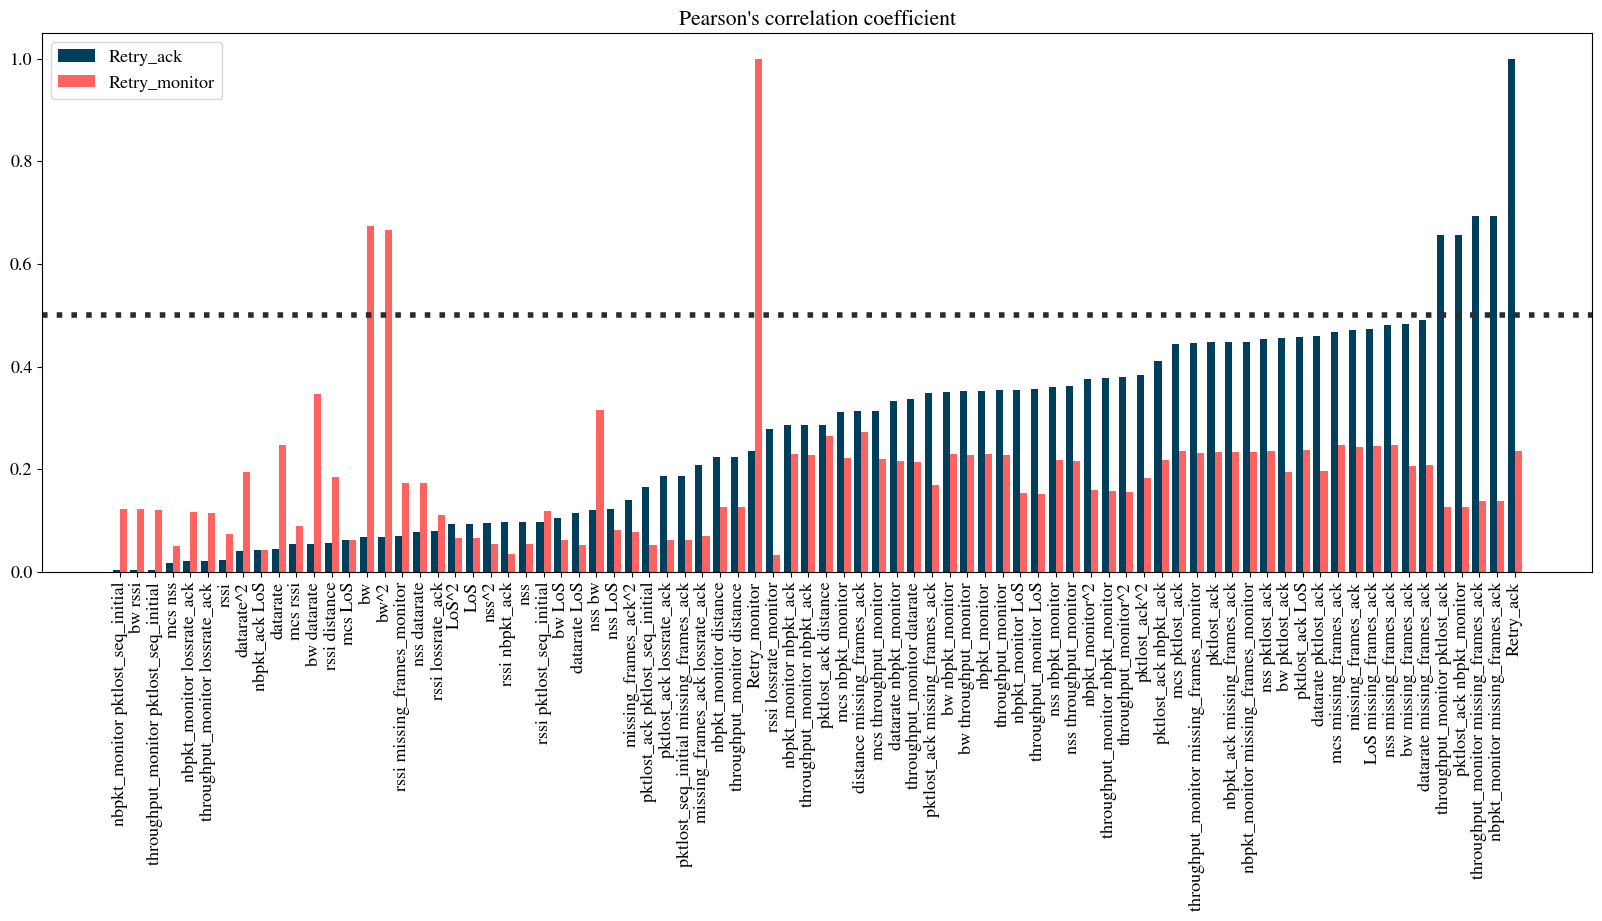

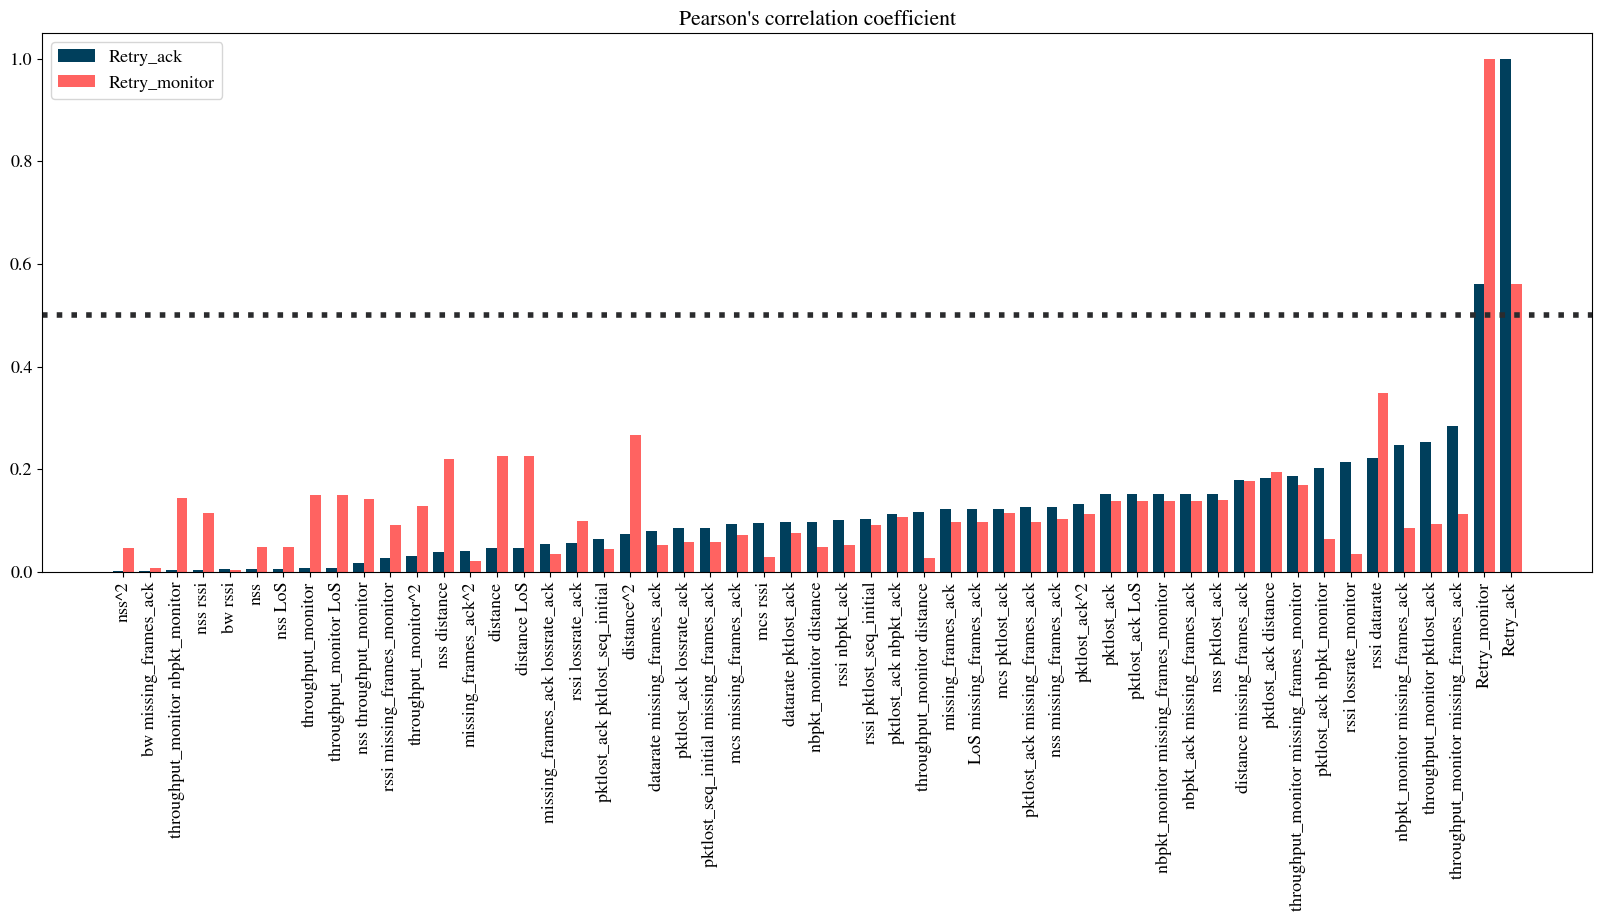

In [12]:
### Construction des corrélations sur les retry. C'est ici qu'on choisi le type de corrélation

X = data_cleaned.drop(['time', 'Scenario', 'antenna', 'bad_fcs', 'retry', 'retry_monitor', 'retry_ack'], axis=1, errors='ignore')
y_loss = data_cleaned['retry_ack'].copy()
y_retry = data_cleaned['retry_monitor'].copy()
#this line draw the plot
y1_corr, y2_corr = features_correlation_simple(X, y_loss, y_retry, scenario=data_cleaned['Scenario'], label=['Retry_ack', 'Retry_monitor'], degree=2, method='pearson', threshold=threshold)
plt.title('Pearson\'s correlation coefficient')
#plt.savefig('figures/Pearson_corr_retry.png', dpi=200, bbox_inches='tight')

X = data_cleaned_sat.drop(['time', 'Scenario', 'antenna', 'bad_fcs','retry_ack','retry_monitor','retry'], axis=1, errors='ignore')
y_loss = data_cleaned_sat['retry_ack'].copy()
y_retry = data_cleaned_sat['retry_monitor'].copy()
y1_corr, y2_corr = features_correlation_simple(X, y_loss, y_retry, scenario=data_cleaned_sat['Scenario'], label=['Retry_ack', 'Retry_monitor'], degree=2, method='pearson', threshold=threshold)
#print(y1_corr, y2_corr)
plt.title('Pearson\'s correlation coefficient')
#plt.savefig('figures/Pearson_corr_retry.png', dpi=200, bbox_inches='tight')


X = data_cleaned_unsat.drop(['time', 'Scenario', 'antenna', 'bad_fcs','retry_ack','retry_monitor','retry'], axis=1, errors='ignore')
y_loss = data_cleaned_unsat['retry_ack'].copy()
y_retry = data_cleaned_unsat['retry_monitor'].copy()
y1_corr, y2_corr = features_correlation_simple(X, y_loss, y_retry, scenario=data_cleaned_unsat['Scenario'], label=['Retry_ack', 'Retry_monitor'], degree=2, method='pearson', threshold=threshold)
#print(y1_corr, y2_corr)
plt.title('Pearson\'s correlation coefficient')
#plt.savefig('figures/Pearson_corr_retry.png', dpi=200, bbox_inches='tight')

In [13]:
y1_corr[y1_corr>=0.5]

Retry_ack        1.00000
Retry_monitor    0.56176
Name: Retry_ack, dtype: float64

/tmp/ipykernel_2200417/832691868.py:11: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  y1_corr = poly_features.corr(method=method)[label[0]]
/tmp/ipykernel_2200417/832691868.py:12: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  y2_corr = poly_features.corr()[label[1]]
/tmp/ipykernel_2200417/832691868.py:11: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  y1_corr = poly_features.corr(method=method)[label[0]]
/tmp/ipykernel_2200417/832691868.py:12: FutureWarning: The default value o

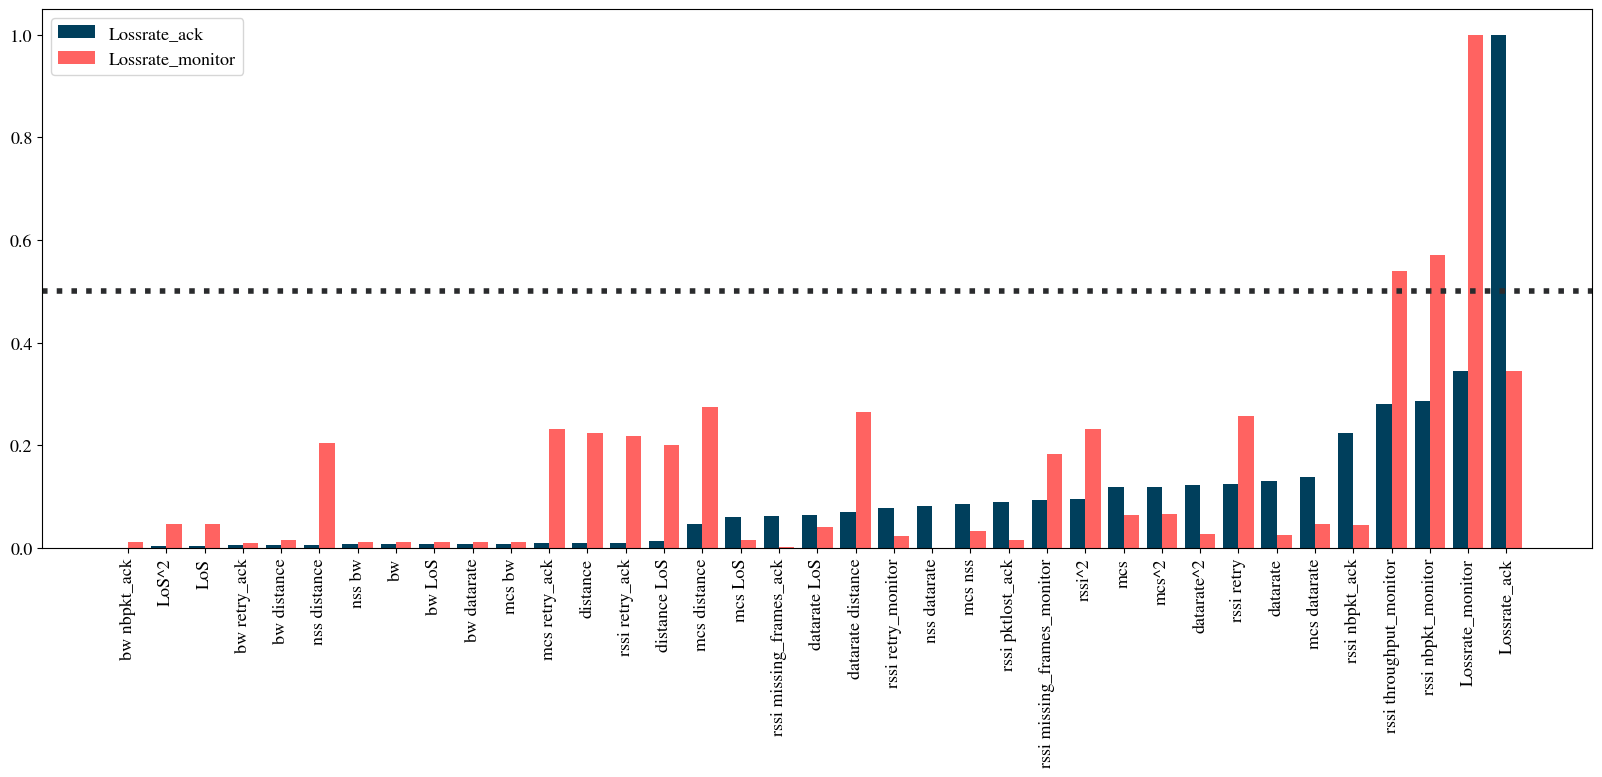

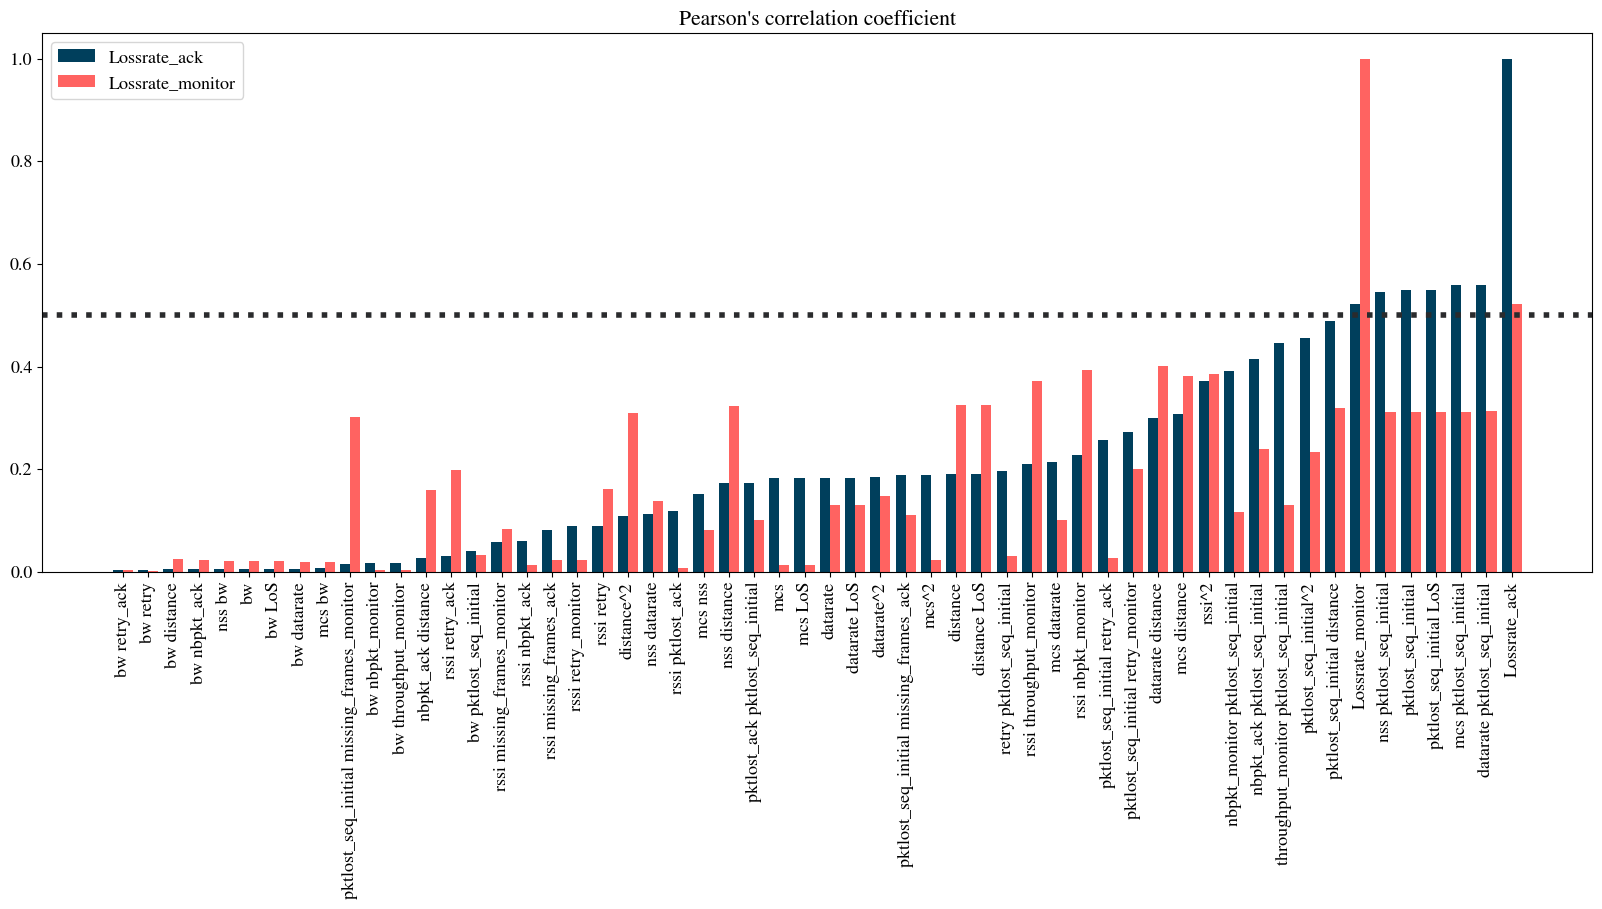

In [14]:
### Construction des corrélations sur le loss rate. C'est ici qu'on choisi le type de corrélation


X = data_cleaned.drop(['time', 'Scenario', 'antenna', 'bad_fcs', 'pktlost_seq_new', 'pktlost_seq_initial', 'lossrate_ack', 'lossrate_monitor'], axis=1, errors='ignore')
y_loss = data_cleaned['lossrate_ack'].copy()
y_retry = data_cleaned['lossrate_monitor'].copy()
features_correlation_simple(X, y_loss, y_retry, scenario=data_cleaned['Scenario'], label=['Lossrate_ack', 'Lossrate_monitor'], degree=2, method='pearson', threshold = threshold)
#plt.title('Pearson\'s correlation coefficient')
#plt.savefig('figures/pearson_corr_lossrate.png', dpi=200, bbox_inches='tight')

X = data_cleaned_unsat.drop(['time', 'Scenario', 'antenna', 'bad_fcs','lossrate_ack','lossrate_monitor'], axis=1, errors='ignore')
y_loss = data_cleaned_unsat['lossrate_ack'].copy()
y_retry = data_cleaned_unsat['lossrate_monitor'].copy()
y_corr1,y_corr=features_correlation_simple(X, y_loss, y_retry, scenario=data_cleaned_unsat['Scenario'], label=['Lossrate_ack', 'Lossrate_monitor'], degree=2, method='pearson', threshold = threshold)
plt.title('Pearson\'s correlation coefficient')
plt.savefig('figures/pearson_corr_lossrate.png', dpi=200, bbox_inches='tight')


#X = data_cleaned_sat.drop(['time', 'Scenario', 'antenna', 'bad_fcs','lossrate_ack','lossrate_monitor'], axis=1, errors='ignore')
#y_loss = data_cleaned_sat['lossrate_ack'].copy()
#y_retry = data_cleaned_sat['lossrate_monitor'].copy()
#y_corr1,y_corr=features_correlation_simple(X, y_loss, y_retry, scenario=data_cleaned_sat['Scenario'], label=['Lossrate_ack', 'Lossrate_monitor'], degree=2, method='pearson', threshold = threshold)
#plt.title('Pearson\'s correlation coefficient')
#plt.savefig('figures/pearson_corr_lossrate.png', dpi=200, bbox_inches='tight')

/tmp/ipykernel_2200417/832691868.py:11: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  y1_corr = poly_features.corr(method=method)[label[0]]
/tmp/ipykernel_2200417/832691868.py:12: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  y2_corr = poly_features.corr()[label[1]]
/tmp/ipykernel_2200417/832691868.py:11: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  y1_corr = poly_features.corr(method=method)[label[0]]
/tmp/ipykernel_2200417/832691868.py:12: FutureWarning: The default value o

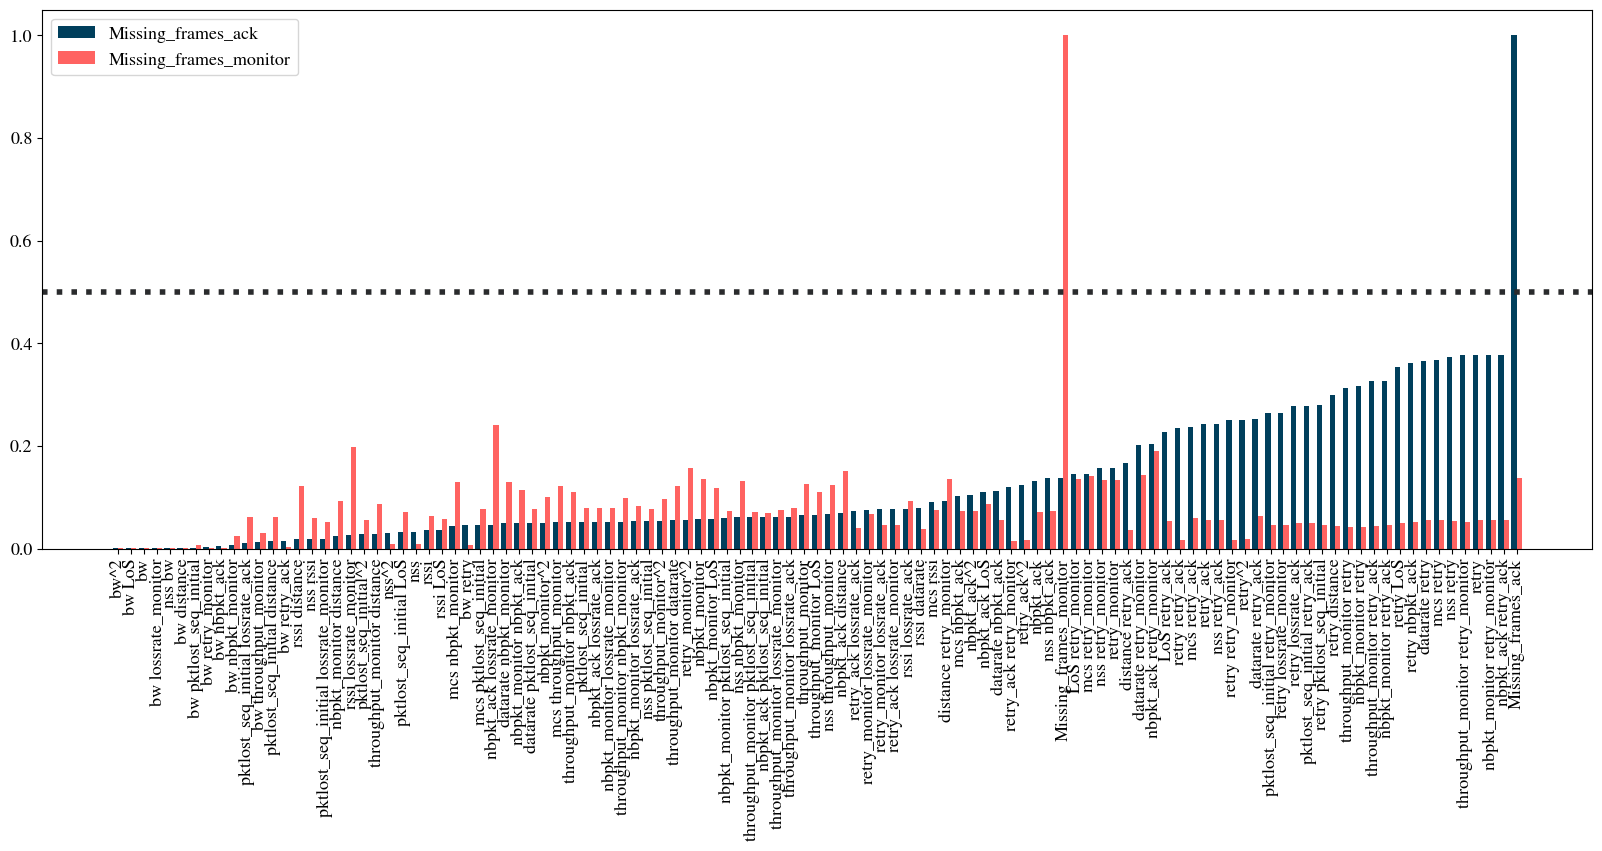

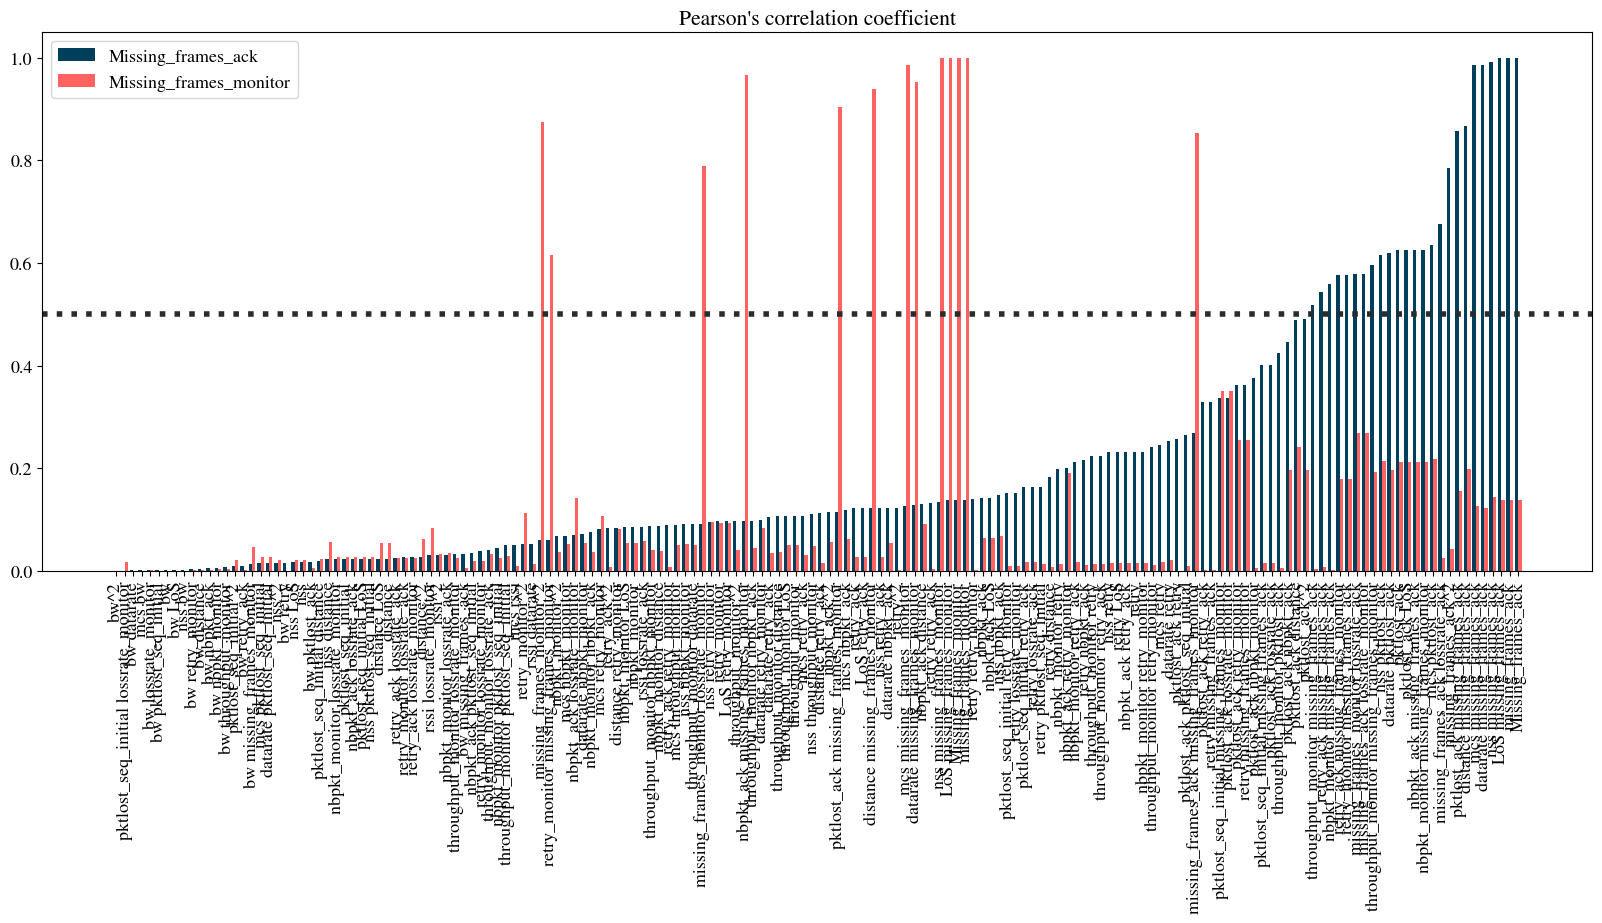

In [15]:
X = data_cleaned.drop(['time', 'Scenario', 'antenna', 'bad_fcs', 'missing_frames_ack', 'missing_frames_monitor', 'pktlost_ack'], axis=1, errors='ignore')
y_loss = data_cleaned['missing_frames_ack'].copy()
y_retry = data_cleaned['missing_frames_monitor'].copy()
features_correlation_simple(X, y_loss, y_retry, scenario=data_cleaned['Scenario'], label=['Missing_frames_ack', 'Missing_frames_monitor'], degree=2, method='pearson', threshold=threshold)
#plt.title('Pearson\'s correlation coefficient')
#plt.savefig('figures/pearson_corr_missingframes.png', dpi=200, bbox_inches='tight')


X = data_cleaned_unsat.drop(['time', 'Scenario', 'antenna', 'bad_fcs'], axis=1, errors='ignore')
y_loss = data_cleaned_unsat['missing_frames_ack'].copy()
y_retry = data_cleaned_unsat['missing_frames_monitor'].copy()
features_correlation_simple(X, y_loss, y_retry, scenario=data_cleaned_unsat['Scenario'], label=['Missing_frames_ack', 'Missing_frames_monitor'], degree=2, method='pearson', threshold=threshold)
plt.title('Pearson\'s correlation coefficient')
plt.savefig('figures/pearson_corr_missingframes.png', dpi=200, bbox_inches='tight')

#X = data_cleaned_sat.drop(['time', 'Scenario', 'antenna', 'bad_fcs'], axis=1, errors='ignore')
#y_loss = data_cleaned_sat['missing_frames_ack'].copy()
#y_retry = data_cleaned_sat['missing_frames_monitor'].copy()
#features_correlation_simple(X, y_loss, y_retry, scenario=data_cleaned_unsat['Scenario'], label=['Missing_frames_ack', 'Missing_frames_monitor'], degree=2, method='pearson', threshold=threshold)
#plt.title('Pearson\'s correlation coefficient')
#plt.savefig('figures/pearson_corr_missingframes.png', dpi=200, bbox_inches='tight')

In [12]:
def correlations_per_scenario(data, data_all, degree=2, metric = 'retry_monitor', type='pearson'):
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    poly_features = poly.fit_transform(data)
    poly_features = pd.DataFrame(poly_features, columns=poly.get_feature_names_out(input_features=data.columns))
    poly_features[metric] = data_all[metric]
    poly_features['Scenario'] = data_all['Scenario']
    correlation_complete = pd.DataFrame()
    for i in data_all['Scenario'].unique():
        a = pd.DataFrame(data=poly_features.loc[data_all['Scenario'] == i].corr(method=type)[metric])
        # a['Scenario'] = i
        # print(poly_features.loc[data_all['Scenario'] == i].corr()['retry_monitor'])
        correlation_complete = pd.concat([correlation_complete, a], axis=1)
    correlation_complete = correlation_complete.sort_index(axis=1)
    correlation_complete.columns = data_all['Scenario'].unique()
    return correlation_complete

<h4>Correlation heatmaps</h4>
The heatmaps only show selected features (chosen with trial and error) so as to have legible figures. 

In [ ]:
data_new = data_all.drop(['time', 'retry', 'retry_monitor', 'Scenario', 'antenna', 'lossrate_ack', 'lossrate_monitor', 'retry_ack', 'missing_frames_ack', 'distance', 'pktlost_seq_new', 'pktlost_ack', 'nss', 'LoS', 'missing_frames_monitor', 'rssi', 'bw', 'nbpkt_ack', 'bad_fcs'], axis=1, errors='ignore')
data_new.dropna(inplace=True)
correlations_complete = correlations_per_scenario(data=data_new, data_all=data_all, degree=2, metric='lossrate_monitor')
plt.figure(figsize=(22,9))
plt.subplot(1,2,1)
plt.title('Pearson\'s correlation: Lossrate')
sns.heatmap(data=correlations_complete, cmap=sns.diverging_palette(h_neg=220, h_pos=15, s=100, l=40, as_cmap=True))
plt.subplot(1,2,2)
plt.title('Pearson\'s correlation: Retry')
correlations_complete = correlations_per_scenario(data=data_new, data_all=data_all, degree=2, metric='retry_monitor')
sns.heatmap(data=correlations_complete, cmap=sns.diverging_palette(h_neg=220, h_pos=15, s=100, l=40, as_cmap=True))
plt.show()
plt.savefig('figures/pearson_corr_heatmaps.png', dpi=200, bbox_inches='tight')

<h4>Correlation conclusions</h4>

**THIS IS NOT VALID ANY MORE**

**Retry rate** (retries/nb frames captured by monitor)
<li>It will likely be difficult to build a precise prediction model. All correlation coefficients show very weak links between the retry rate (number of retries / number of frames counted by monitor) and any other feature. It is less true for specific scenarios, i.e., the anechoic chamber and the 3rd floor with obstacle. </li>


**Lossrate** (sequence number errors/nb frames captured by monitor)
<li>The correlationas are much stronger, however they are very different for the anechoic chamber and the corridor (as we expected). Since we're building linear models for the moment, we focus a bit more on Spearman's correlation coefficients. </li>
<li>The lossrate in the corridor scenarios (everything 1H, 2nd, and 3rd) is most strongly correlated to the nbpkt_monitor and the throughput_monitor. These two features are almost the same, as the frame length is usually fairly stable so the calculated throughput is a linear function of the number of frames. I believe that this correlation will be less strong once we have the data for an unsaturated scenario, because right now the number of frames received directly measures the quality of the communication. </li> 
<li>In the anechoic chamber, the lossrate seems to most strongly correlate with the datarate and the mcs. I am not exactly sure why, but these two features are also very linked to each other. The datarate is mostly dependent on the GI, NSS, BW, and MCS. The first three features are mainly constant in all scenarios, so the datarate and the MCS are almost a linear function of each other. This might capture the behavior the the rate adaptation algorthm, but also the data from the anechoic chamber is fairly limited when it comes to the distribution of the lossrate values. Most of the values are extremely close to 0, and the only distances for which we have lossrates > 0.2 are 1 and 2 meters. This indicated that it is more the signal propagation (not enough path diversity for MIMO) than the actualy signal strength/quality that generated these losses. As a result, for the moment it is difficult to make conclusive thoughts on the behavior measured in the anechoic chamber. </li>
<li>I try to look at Kendall's correlation as well, because some mention it as an improvement of Spearman's, but I am still not sure about the interpretation. "Intuitively, the Kendall correlation between two variables will be high when observations have a similar (or identical for a correlation of 1) rank (i.e. relative position label of the observations within the variable: 1st, 2nd, 3rd, etc.) between the two variables, and low when observations have a dissimilar (or fully different for a correlation of −1) rank between the two variables." This makes sense for us, as it means that if the sorted observations have a similar order for two different features, then those two features are correlated.</li>
<li>As before, I'll try to make a general model that covers all the data, and a specific model for the corridor and the anechoic data</li>

<h4>To do</h4>
Do a distribution test to see what's going on with the data on the 3rd floor with obstacle.

<h2>Building the model</h2>

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

linear_pipe = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()), 
            ("regressor", LinearRegression()),]
)
poly_pipe = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")),
           ("poly", PolynomialFeatures(degree=2, include_bias=False)),
            ("scaler", StandardScaler()), 
            ("regressor", LinearRegression()),]
)

def plot_model(X_train, y_train, X_test, y_test, model_class, alphas, antenna_names=[], plot = 1, **model_kargs):
    for alpha in alphas:
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        # linear model
        linear_pipe = Pipeline(
            steps=[("imputer", SimpleImputer(strategy="median")),
                    ("scaler", StandardScaler()), 
                    ("regressor", model),]
        )
        linear_model = linear_pipe.fit(X_train, y_train)
        y_predict_linear = linear_model.predict(X_test)
        linear_score = linear_model.score(X_test, y_test)
        # calculate sorted coefficients
        feature_names = linear_model.named_steps['scaler'].get_feature_names_out(input_features=X_train.columns.append(antenna_names))
        feature_coefs = linear_model.named_steps['regressor'].coef_
        sorted_indexes = abs(feature_coefs).argsort()
        sorted_coef_linear = np.c_[feature_names[sorted_indexes], feature_coefs[sorted_indexes]]
        
        # polynomial model
        poly_pipe = Pipeline(
            steps=[("imputer", SimpleImputer(strategy="median")),
                   ("poly", PolynomialFeatures(degree=2, include_bias=False)),
                    ("scaler", StandardScaler()), 
                    ("regressor", model),]
        )
        poly_model = poly_pipe.fit(X_train, y_train)
        y_predict_poly = poly_model.predict(X_test)
        poly_score = poly_model.score(X_test,y_test)
        # calculate sorted coefficients
        feature_names = poly_model.named_steps['poly'].get_feature_names_out(input_features=X_train.columns.append(antenna_names))
        feature_coefs = poly_model.named_steps['regressor'].coef_
        sorted_indexes = abs(feature_coefs).argsort()
        sorted_coef_poly = np.c_[feature_names[sorted_indexes], feature_coefs[sorted_indexes]]
        
        if plot:
            plt.rcParams["figure.figsize"] = (5,7)
            plt.figure(1)
            plt.grid()
            sns.scatterplot(x=y_test, y=y_predict_linear, alpha=0.3, s=40, linewidth=0.1, hue=hue_markers, palette=colorlist_summer_divergent[0:len(hue_markers.unique())])
            plt.plot(y_test, y_test, label='Ideal', c='k')
            plt.xlabel('Groud truth', fontsize=20)
            plt.ylabel('Prediction', fontsize=20)        
            plt.legend(loc='lower right', fontsize=16)
            plt.xticks(fontsize=16)
            plt.yticks(fontsize=16)
            plt.ylim([-0.2, 1.2])
            plt.xlim([-0.2, 1.2])
            

            plt.figure(2)
            plt.grid()
            sns.scatterplot(x=y_test, y=y_predict_poly, alpha=0.3, s=40, linewidth=0.1, hue=hue_markers, palette = colorlist_summer_divergent[0:len(hue_markers.unique())])
            plt.plot(y_test, y_test, label='Ideal', c='k')
            plt.xlabel('Groud truth', fontsize=20)
            plt.ylabel('Prediction', fontsize=20)
            plt.legend(loc='lower right', fontsize=16)
            plt.xticks(fontsize=16)
            plt.yticks(fontsize=16)        
            plt.ylim([-0.2, 1.2])
            plt.xlim([-0.2, 1.2])
        
            print("Linear and poly R2 scores: ", linear_score, poly_score)
            print("Linear and poly mean absolute error: ", mean_absolute_error(y_test, y_predict_linear), mean_absolute_error(y_test, y_predict_poly))
            print("Linear and poly RMSE: ", mean_squared_error(y_test, y_predict_linear, squared=False), mean_squared_error(y_test, y_predict_poly, squared=False))
        return linear_model, poly_model, sorted_coef_linear, sorted_coef_poly, y_test, y_predict_poly

**<h4>Retry rate </h4>**

In [14]:
data_cleaned.columns

#data_cleaned_unsat.columns

Index(['time', 'mcs', 'nss', 'bw', 'rssi', 'throughput_monitor', 'datarate',
       'pktlost_ack', 'nbpkt_monitor', 'retry', 'nbpkt_ack',
       'pktlost_seq_initial', 'distance', 'antenna', 'LoS', 'Scenario',
       'retry_ack', 'retry_monitor', 'missing_frames_ack',
       'missing_frames_monitor', 'lossrate_ack', 'lossrate_monitor'],
      dtype='object')

Linear and poly R2 scores:  0.4074148851898014 0.6039242054861211
Linear and poly mean absolute error:  0.04442383555669124 0.03681669724600189
Linear and poly RMSE:  0.09241894863704962 0.07555701734623911
Linear and poly R2 scores:  0.4074148851898014 0.6039242054861211
Linear and poly mean absolute error:  0.04442383555669124 0.03681669724600189
Linear and poly RMSE:  0.09241894863704962 0.07555701734623911
Linear and poly R2 scores:  0.5847001400837759 0.7179639047900541
Linear and poly mean absolute error:  0.06482640695185757 0.04739306306129852
Linear and poly RMSE:  0.09716820921509091 0.08007476138432888


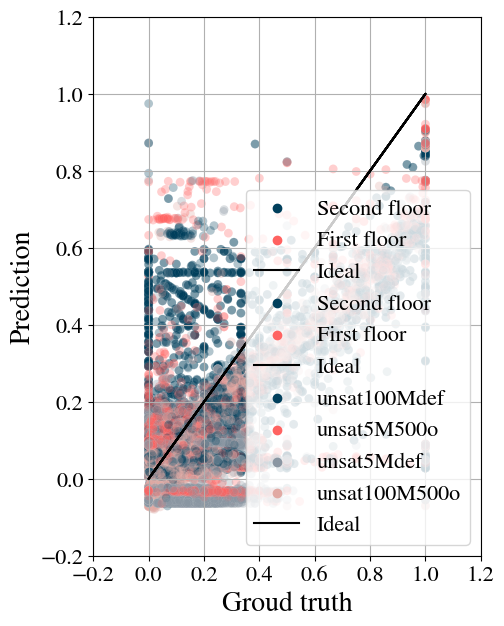

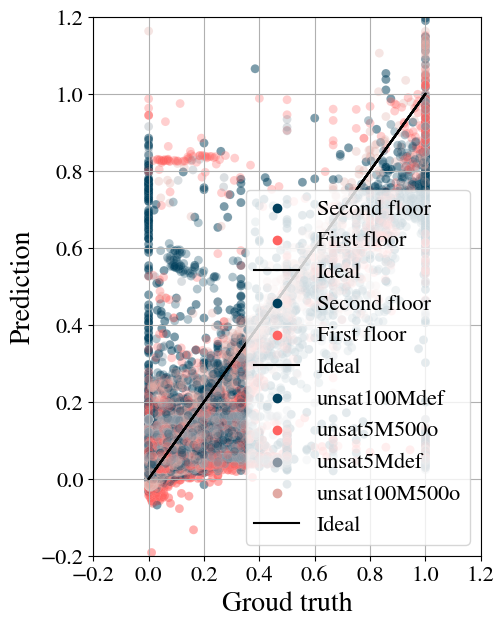

In [15]:
#Models for the retry monitor metric

from sklearn.model_selection import StratifiedShuffleSplit

#X = data_cleaned.drop(['time', 'retry', 'retry_ack', 'retry_monitor', 'Scenario', 'LoS', 'antenna', 'mcs', 'nss', 'bw', 'throughput_monitor', 'pktlost_seq_initial'], axis=1, errors='ignore')

#métriques surlesquelles on apprend
X_all = data_cleaned[['mcs', 'nss', 'bw', 'rssi', 'datarate', 'throughput_monitor', 'nbpkt_ack']]
#métrique à prédire
y_all = data_cleaned['retry_monitor'].copy()

X_unsat = data_cleaned_unsat[['mcs', 'nss', 'bw', 'rssi', 'datarate', 'throughput_monitor', 'nbpkt_ack']]
y_unsat = data_cleaned_unsat['retry_monitor'].copy()

X_sat = data_cleaned_sat[['mcs', 'nss', 'bw', 'rssi', 'datarate', 'throughput_monitor', 'nbpkt_ack']]
y_sat = data_cleaned_sat['retry_monitor'].copy()



#split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
#bins = np.linspace(0, len(data_cleaned) , 20)
#y_binned = np.digitize(y, bins)
#for train_index, test_index in split.split(data_cleaned, y_binned):
#    hue_markers = data_cleaned['Scenario'].loc[test_index]
#    X_train = X.loc[train_index]
#    X_test = X.loc[test_index]
#    y_train = y.loc[train_index]
#    y_test = y.loc[test_index]
#linear_model, poly_model, sorted_coef_linear, sorted_coef_poly, y_test_all, y_predict_poly_all =  plot_model(X_train, y_train, X_test, y_test, Ridge, [1])

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
bins = np.linspace(0, len(data_cleaned_unsat) , 20)
y_binned = np.digitize(y_unsat, bins)

#Modele all
for train_index, test_index in split.split(data_cleaned_unsat, y_binned):
    hue_markers = data_cleaned['Scenario'].loc[test_index]
    X_train = X_all.loc[train_index]
    X_test = X_all.loc[test_index]
    y_train = y_all.loc[train_index]
    y_test = y_all.loc[test_index]
linear_model_all, poly_model_all, sorted_coef_linear, sorted_coef_poly, y_test_all, y_predict_poly_all =  plot_model(X_train, y_train, X_test, y_test, Ridge, [1])

#Modele sat
for train_index, test_index in split.split(data_cleaned_unsat, y_binned):
    hue_markers = data_cleaned_sat['Scenario'].loc[test_index]
    X_train = X_sat.loc[train_index]
    X_test = X_sat.loc[test_index]
    y_train = y_sat.loc[train_index]
    y_test = y_sat.loc[test_index]
linear_model_sat, poly_model_sat, sorted_coef_linear, sorted_coef_poly, y_test_all, y_predict_poly_all =  plot_model(X_train, y_train, X_test, y_test, Ridge, [1])

#Modele unsat
for train_index, test_index in split.split(data_cleaned_unsat, y_binned):
    hue_markers = data_cleaned_unsat['Scenario'].loc[test_index]
    X_train = X_unsat.loc[train_index]
    X_test = X_unsat.loc[test_index]
    y_train = y_unsat.loc[train_index]
    y_test = y_unsat.loc[test_index]
linear_model_unsat, poly_model_unsat, sorted_coef_linear, sorted_coef_poly, y_test_all, y_predict_poly_all =  plot_model(X_train, y_train, X_test, y_test, Ridge, [1])




Linear and poly R2 scores:  0.4074148851898014 0.6039242054861211
Linear and poly mean absolute error:  0.04442383555669124 0.03681669724600189
Linear and poly RMSE:  0.09241894863704962 0.07555701734623911
Linear and poly R2 scores:  0.4074148851898014 0.6039242054861211
Linear and poly mean absolute error:  0.04442383555669124 0.03681669724600189
Linear and poly RMSE:  0.09241894863704962 0.07555701734623911
Linear and poly R2 scores:  0.5847001400837759 0.7179639047900541
Linear and poly mean absolute error:  0.06482640695185757 0.04739306306129852
Linear and poly RMSE:  0.09716820921509091 0.08007476138432888


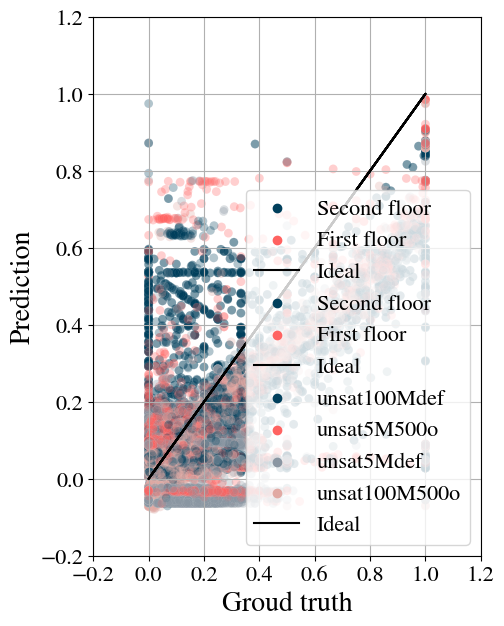

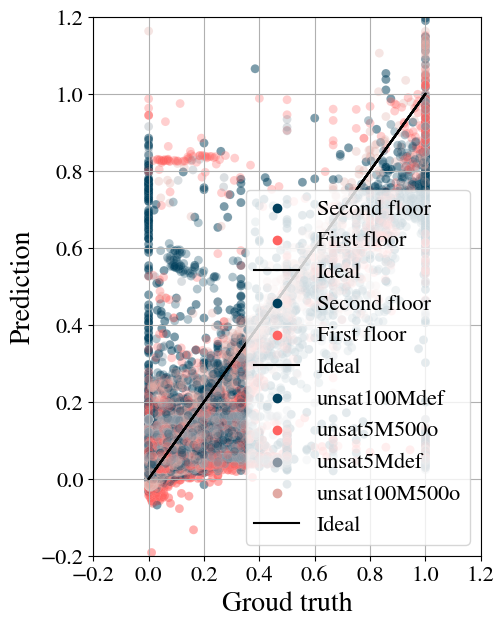

In [16]:
#Models for the retry ack metric

from sklearn.model_selection import StratifiedShuffleSplit

#X = data_cleaned.drop(['time', 'retry', 'retry_ack', 'retry_monitor', 'Scenario', 'LoS', 'antenna', 'mcs', 'nss', 'bw', 'throughput_monitor', 'pktlost_seq_initial'], axis=1, errors='ignore')
#X = data_cleaned[['mcs', 'nss', 'bw', 'rssi', 'datarate', 'throughput_monitor', 'nbpkt_ack']]
#y = data_cleaned['retry_ack'].copy()


#métriques surlesquelles on apprend
X_all = data_cleaned[['mcs', 'nss', 'bw', 'rssi', 'datarate', 'throughput_monitor', 'nbpkt_ack']]
#métrique à prédire
y_all = data_cleaned['retry_monitor'].copy()

X_unsat = data_cleaned_unsat[['mcs', 'nss', 'bw', 'rssi', 'datarate', 'throughput_monitor', 'nbpkt_ack']]
y_unsat = data_cleaned_unsat['retry_monitor'].copy()

X_sat = data_cleaned_sat[['mcs', 'nss', 'bw', 'rssi', 'datarate', 'throughput_monitor', 'nbpkt_ack']]
y_sat = data_cleaned_sat['retry_monitor'].copy()


#split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
#bins = np.linspace(0, len(data_cleaned) , 20)
#y_binned = np.digitize(y, bins)
#for train_index, test_index in split.split(data_cleaned, y_binned):
#    hue_markers = data_cleaned['Scenario'].loc[test_index]
#    X_train = X.loc[train_index]
#    X_test = X.loc[test_index]
#    y_train = y.loc[train_index]
#    y_test = y.loc[test_index]
#linear_model, poly_model, sorted_coef_linear, sorted_coef_poly, y_test_all, y_predict_poly_all =  plot_model(X_train, y_train, X_test, y_test, Ridge, [1])

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
bins = np.linspace(0, len(data_cleaned) , 20)
y_binned = np.digitize(y_unsat, bins)


#Model all
for train_index, test_index in split.split(data_cleaned_unsat, y_binned):
    hue_markers = data_cleaned['Scenario'].loc[test_index]
    X_train = X_all.loc[train_index]
    X_test = X_all.loc[test_index]
    y_train = y_all.loc[train_index]
    y_test = y_all.loc[test_index]
linear_model_all, poly_model_all, sorted_coef_linear, sorted_coef_poly, y_test_all, y_predict_poly_all =  plot_model(X_train, y_train, X_test, y_test, Ridge, [1])

#Model sat
for train_index, test_index in split.split(data_cleaned_unsat, y_binned):
    hue_markers = data_cleaned_sat['Scenario'].loc[test_index]
    X_train = X_sat.loc[train_index]
    X_test = X_sat.loc[test_index]
    y_train = y_sat.loc[train_index]
    y_test = y_sat.loc[test_index]
linear_model_sat, poly_model_sat, sorted_coef_linear, sorted_coef_poly, y_test_all, y_predict_poly_all =  plot_model(X_train, y_train, X_test, y_test, Ridge, [1])

#Model unsat
for train_index, test_index in split.split(data_cleaned_unsat, y_binned):
    hue_markers = data_cleaned_unsat['Scenario'].loc[test_index]
    X_train = X_unsat.loc[train_index]
    X_test = X_unsat.loc[test_index]
    y_train = y_unsat.loc[train_index]
    y_test = y_unsat.loc[test_index]
linear_model_unsat, poly_model_unsat, sorted_coef_linear, sorted_coef_poly, y_test_all, y_predict_poly_all =  plot_model(X_train, y_train, X_test, y_test, Ridge, [1])



**<h4>Lossrate</h4>**
The lossrate here is the ratio between the number of frames counted as missing (using the initial computation based on the missing sequence numbers where we only record the event that a loss occured, but we do not know if it is a single frame or several) and the number of frames captured by the monitor.

Linear and poly R2 scores:  0.782415286098481 0.8563870531475335
Linear and poly mean absolute error:  0.09307285933646149 0.06770567842099817
Linear and poly RMSE:  0.14409692537981367 0.11706776321981867
Linear and poly R2 scores:  0.782415286098481 0.8563870531475335
Linear and poly mean absolute error:  0.09307285933646149 0.06770567842099817
Linear and poly RMSE:  0.14409692537981367 0.11706776321981867
Linear and poly R2 scores:  0.5189301281314805 0.7320189442357501
Linear and poly mean absolute error:  0.14087838074550768 0.10175867042888731
Linear and poly RMSE:  0.19292065213838797 0.1439881290717916


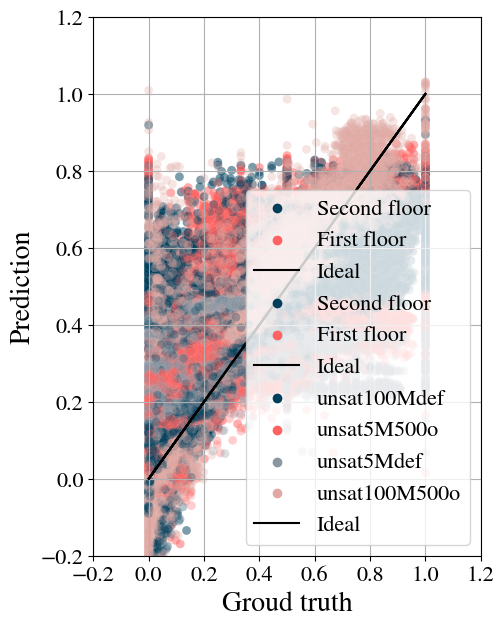

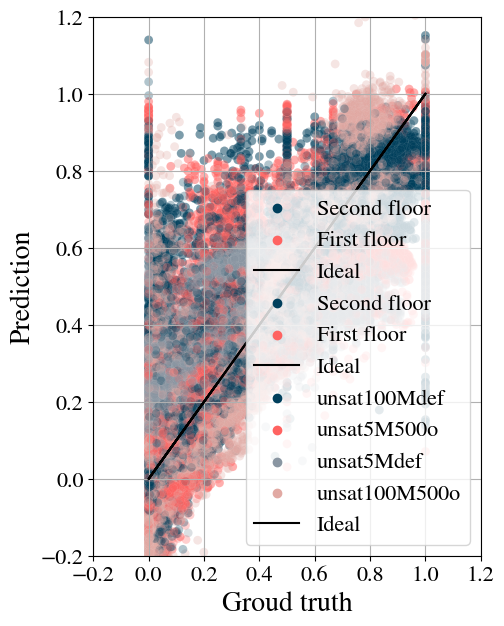

In [17]:
#Models for the loss rate metric

from sklearn.model_selection import StratifiedShuffleSplit

features = ['nbpkt_monitor', 'mcs', 'datarate', 'throughput_monitor', 'rssi', 'nbpkt_ack']

#X = data_cleaned.drop(['time', 'retry', 'retry_ack', 'retry_monitor', 'Scenario', 'LoS', 'antenna', 'mcs', 'nss', 'bw', 'throughput_monitor', 'pktlost_seq_initial'], axis=1, errors='ignore')
#X = data_cleaned[features]
#y = data_cleaned['lossrate_monitor'].copy()

#split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
#bins = np.linspace(0, len(data_cleaned) , 20)
#y_binned = np.digitize(y, bins)
#for train_index, test_index in split.split(data_cleaned, y_binned):
#    hue_markers = data_cleaned['Scenario'].loc[test_index]
#    X_train = X.loc[train_index]
#    X_test = X.loc[test_index]
#    y_train = y.loc[train_index]
#    y_test = y.loc[test_index]
#linear_model_all, poly_model_all, sorted_coef_linear_all, sorted_coef_poly_all, y_test_all, y_predict_poly_all =  plot_model(X_train, y_train, X_test, y_test, Ridge, [1])


#X = data_cleaned_unsat.drop(['time', 'retry', 'retry_ack', 'retry_monitor', 'Scenario', 'LoS', 'antenna', 'mcs', 'nss', 'bw', 'throughput_monitor', 'pktlost_seq_initial'], axis=1, errors='ignore')
X_all = data_cleaned[features]
y_all = data_cleaned['lossrate_monitor'].copy()

X_sat = data_cleaned_sat[features]
y_sat = data_cleaned_sat['lossrate_monitor'].copy()

X_unsat = data_cleaned_unsat[features]
y_unsat = data_cleaned_unsat['lossrate_monitor'].copy()


split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
bins = np.linspace(0, len(data_cleaned) , 20)
y_binned = np.digitize(y_unsat, bins)

for train_index, test_index in split.split(data_cleaned_unsat, y_binned):
    hue_markers = data_cleaned['Scenario'].loc[test_index]
    X_train = X_all.loc[train_index]
    X_test = X_all.loc[test_index]
    y_train = y_all.loc[train_index]
    y_test = y_all.loc[test_index]
linear_model_all, poly_model_all, sorted_coef_linear_all, sorted_coef_poly_all, y_test_all, y_predict_poly_all =  plot_model(X_train, y_train, X_test, y_test, Ridge, [1])

for train_index, test_index in split.split(data_cleaned_unsat, y_binned):
    hue_markers = data_cleaned_sat['Scenario'].loc[test_index]
    X_train = X_sat.loc[train_index]
    X_test = X_sat.loc[test_index]
    y_train = y_sat.loc[train_index]
    y_test = y_sat.loc[test_index]
linear_model_sat, poly_model_sat, sorted_coef_linear_all, sorted_coef_poly_all, y_test_all, y_predict_poly_all =  plot_model(X_train, y_train, X_test, y_test, Ridge, [1])


for train_index, test_index in split.split(data_cleaned_unsat, y_binned):
    hue_markers = data_cleaned_unsat['Scenario'].loc[test_index]
    X_train = X_unsat.loc[train_index]
    X_test = X_unsat.loc[test_index]
    y_train = y_unsat.loc[train_index]
    y_test = y_unsat.loc[test_index]
linear_model_unsat, poly_model_unsat, sorted_coef_linear_all, sorted_coef_poly_all, y_test_all, y_predict_poly_all =  plot_model(X_train, y_train, X_test, y_test, Ridge, [1])



In [18]:
X_sat = data_cleaned[features]
y_sat = data_cleaned['lossrate_monitor'].copy()
#on predit y sat en ayant appris sur poly_model_all (ici unsat)
y_predict_sat=poly_model_all.predict(X_sat)

print("Linear and poly mean absolute error: ", mean_absolute_error(y_sat, y_predict_sat))
print("Linear and poly RMSE: ", mean_squared_error(y_sat, y_predict_sat, squared=False))
print("Linear and poly R2: ", poly_model_all.score(X_sat, y_sat))


Linear and poly mean absolute error:  0.1229400651821611
Linear and poly RMSE:  0.17699358688495553
Linear and poly R2:  0.6341677754411191


<h4>Lossrate model per scenario</h4>

In [20]:
linear_model = {}
poly_model = {}
sorted_coef_linear = {}
sorted_coef_poly = {}
r2_score = {} 
rmse = {}
mae = {}

#for i in frames:
#    data = i.copy()
#    X = data[features]
#    y = data['lossrate_monitor'].copy()
    
for i in frames_unsat:
    data = i.copy()
    X = data[features]
    y = data['lossrate_monitor'].copy()
    
    
    indexes = y.notna()
    X = X.loc[indexes]
    y = y.loc[indexes]
    data = data.loc[indexes]
    data.index = range(len(data))
    X.index = data.index
    y.index = data.index
    
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    bins = np.linspace(0, len(data) , 20)
    y_binned = np.digitize(y, bins)
    
    for train_index, test_index in split.split(data, y_binned):
        # hue_markers = data['Scenario'].loc[test_index]
        X_train = X.loc[train_index]
        X_test = X.loc[test_index]
        y_train = y.loc[train_index]
        y_test = y.loc[test_index]
    linear_model[i['Scenario'][0]], poly_model[i['Scenario'][0]], sorted_coef_linear[i['Scenario'][0]], sorted_coef_poly[i['Scenario'][0]], y_test_all, y_predict_poly_all =  plot_model(X_train, y_train, X_test, y_test, Ridge, [1], plot = 0)
    plt.show()

In [ ]:
linear_model['All Data'] = linear_model_all
poly_model['All Data'] = poly_model_all
sorted_coef_linear['All Data'] = sorted_coef_linear_all
sorted_coef_poly['All Data'] = sorted_coef_poly_all

In [ ]:
def calculate_errors_across_datasets (poly_model, frames=frames, features=features):
    poly_score = pd.DataFrame()
    mae = pd.DataFrame()
    rmse = pd.DataFrame()
    for i in range(len(frames)):
        for j in range(len(frames)):
            #data = frames[j].copy()
            data = frames_unsat[j].copy()
            X = data[features]
            y = data['lossrate_monitor'].copy()
            indexes = y.notna()
            X = X.loc[indexes]
            y = y.loc[indexes]
            data = data.loc[indexes]
            data.index = range(len(data))
            X.index = data.index
            y.index = data.index
            
            split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
            bins = np.linspace(0, len(data) , 20)
            y_binned = np.digitize(y, bins)
            
            for train_index, test_index in split.split(data, y_binned):
                X_test = X.loc[test_index]
                y_test = y.loc[test_index]
            #y_predict_poly = poly_model[frames[i]['Scenario'][0]].predict(X_test)
            #poly_score.loc[i,j] = poly_model[frames[i]['Scenario'][0]].score(X_test,y_test)
            
            y_predict_poly = poly_model[frames_unsat[i]['Scenario'][0]].predict(X_test)
            poly_score.loc[i,j] = poly_model[frames_unsat[i]['Scenario'][0]].score(X_test,y_test)

            mae.loc[i,j] = mean_absolute_error(y_test, y_predict_poly)
            rmse.loc[i,j] = mean_squared_error(y_test, y_predict_poly, squared=False)
        #poly_score.rename({i: frames[i]['Scenario'][0]}, axis=0, inplace=True)
        #mae.rename({i: frames[i]['Scenario'][0]}, axis=0, inplace=True)    
        #rmse.rename({i: frames[i]['Scenario'][0]}, axis=0, inplace=True)
        
        poly_score.rename({i: frames_unsat[i]['Scenario'][0]}, axis=0, inplace=True)
        mae.rename({i: frames_unsat[i]['Scenario'][0]}, axis=0, inplace=True)    
        rmse.rename({i: frames_unsat[i]['Scenario'][0]}, axis=0, inplace=True)
        
    rmse.columns = rmse.index
    mae.columns = mae.index
    poly_score.columns = poly_score.index
    return poly_score, rmse, mae

frames_with_data_all = frames.copy()
frames_with_data_unsat = frames_unsat.copy()
data_copy['Scenario'] = 'All Data'
data_unsat_copy['Scenario'] = 'Data unsat'
#frames_with_data_all.append(data_copy)
frames_with_data_unsat.append(data_unsat_copy)

#score, rmse, mae = calculate_errors_across_datasets(poly_model=poly_model, frames=frames_with_data_all)
score, rmse, mae = calculate_errors_across_datasets(poly_model=poly_model, frames=frames_with_data_unsat)

In [ ]:
def plot_heatmaps(score, rmse, mae, names, color_map = cmap_summer_divergent, linew = 0.5):
    plt.figure(num=1, figsize=(6,5))
    plt.title('Mean absolute error')
    sns.heatmap(mae, cmap = color_map, linewidths=linew, xticklabels=names, yticklabels=names, vmax=0.5, annot=True, fmt='.2f')
    plt.savefig('figures/mae.png', dpi=200, bbox_inches='tight')
    
    plt.figure(num=3, figsize=(6,5))
    plt.title('Root mean square error')
    sns.heatmap(rmse, cmap = color_map, linewidths=linew, xticklabels=names, yticklabels=names, vmax=0.5, annot=True, fmt='.2f')
    plt.savefig('figures/rmse.png', dpi=200, bbox_inches='tight')
    
    plt.figure(num=5, figsize=(6,5))
    plt.title('R2 score')
    sns.heatmap(score, cmap = color_map, linewidths=linew, xticklabels=names, yticklabels=names, vmin=0, annot=True, fmt='.2f')
    plt.savefig('figures/r2_score.png', dpi=200, bbox_inches='tight')

In [ ]:
plot_heatmaps(score, rmse, mae, names=rmse.index)
summary = pd.DataFrame()

print('Mean MAE \n', mae.transpose().mean())
print('Mean RMSE \n', rmse.transpose().mean())
print('Mean R2 \n', score.transpose().mean())

<h4>Mix and match conclusions</h4>
The two outliers now seem to be the 3rd floor obstacle and the anechoic chamber data. I think that removing them might significantly improve the precision, but I will wait for the final results from Thierry before making a decision. We do need to justify why, for both scenarios it will be fairly easy to show that they do not behave as the rest of the data by looking the the Pearson's correlation heatmaps. For the anechoic chamber though, it's interesting that it's actually not that bad at predicting other types of scenarios, but it cannot be predicted by any other dataset except for the complete one. 

<h4>To do:</h4>

Look into the coefficients of the models for the different scenarios. 

Do a mix and match with training data and testing data. 

Change the size of the datasets so that they are all compatible with the smallest one.

Models without the 3rd floor obstacle and the anechoic chamber data.

In [ ]:
#X.drop(index=false)